# <center> Lotka-Volterra </center>
___
<font color='blue'><center>**Carlos del-Castillo-Negrete **</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu</center>
___

- [***Parameter Estimation with Maximal Updated Densities***](https://arxiv.org/pdf/2212.04587.pdf) Pilosov, M., del-Castillo-Negrete, C., Yen, T. Y., Butler, T., & Dawson, C. (2022). Parameter Estimation with Maximal Updated Densities. arXiv preprint arXiv:2212.04587.
___

In [1]:
import pandas as pd
import seaborn as sns
from pydci.log import enable_log, disable_log
from pydci.examples import lotka_volterra
import importlib
import itertools

from pydci import OfflineSequentialSearch, PCAMUDProblem
from pydci.log import enable_log, disable_log, logger
from pydci.examples import lotka_volterra
from pydci.utils import set_seed

## Problem Set-Up

The traditional predator prey model is given by the following system of ordinary differential equations:

$$
\begin{aligned}
& \frac{d x}{d t}=\alpha x-\beta x y \\
& \frac{d y}{d t}=\delta x y-\gamma y
\end{aligned}
$$

where

- $x$ is the number of prey (for example, rabbits);
- $y$ is the number of some predator (for example, foxes);
- $\frac{d y}{d t}$ and $\frac{d x}{d t}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
    
The parameters of the problem $\lambda = [\alpha, \beta, \delta, \gamma]$ are positive real parameters describing the interaction of the two species:

- $\lambda_0 = \alpha=$ growth rate of prey
- $\lambda_1 = \beta$ = death rate of rabbits due to predatation from predators
- $\lambda_2 = \delta=$ factor describing how many consumed prey create a new predator
- $\lambda_3 = \gamma=$ natural death rate of predators


# LV Model Problem class - test params

The LotkaVoleterra model allows us to define a model with a forward solver for simulating the predator-prey system.
For inputs to the class we have:

- `x0` - the time span of the simulation
- `lam_true` - the true parameters of the system
- `solve_ts` - the time step for the forward solver (uses `scipy.integrate.odient`)
- `sample_ts` - the time step for the measurement
- `measurement_noise` - the standard deviation of the measurement noise

We start by initializing the model, using default parameters for now


Solving model sample set: |                    | ▁▃▅ 3/1000 [0%] in 0s (~0s, 214

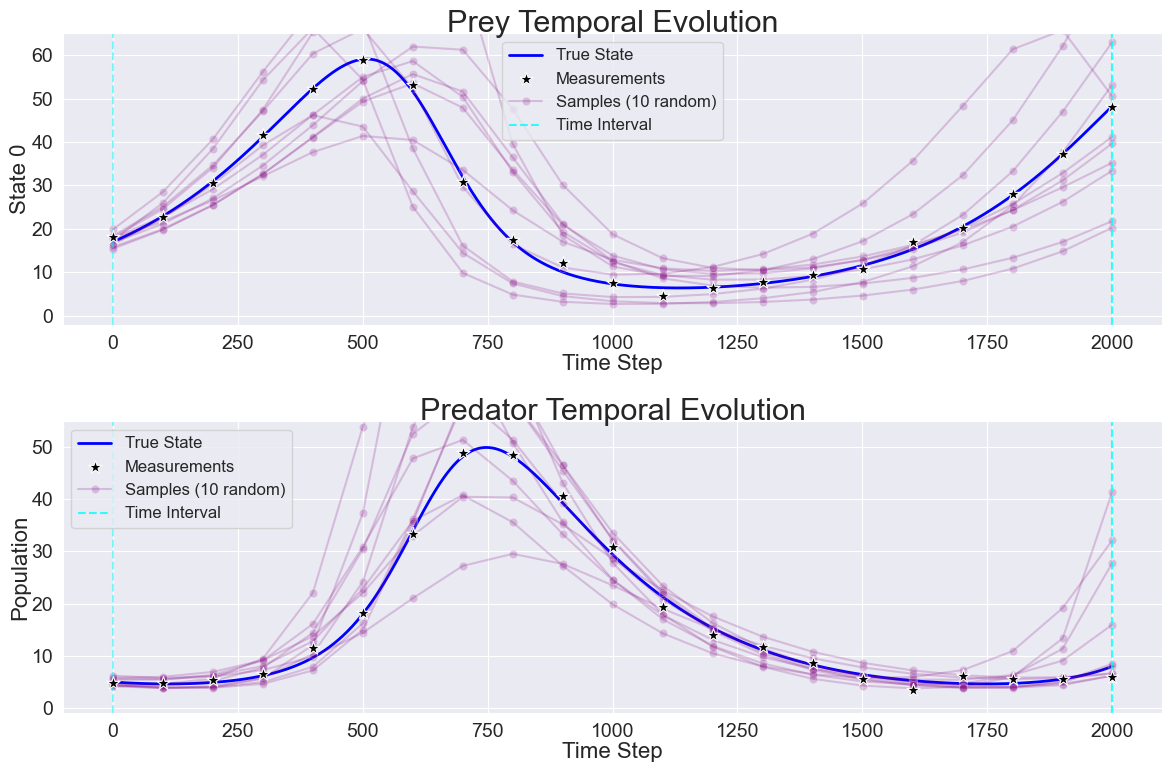

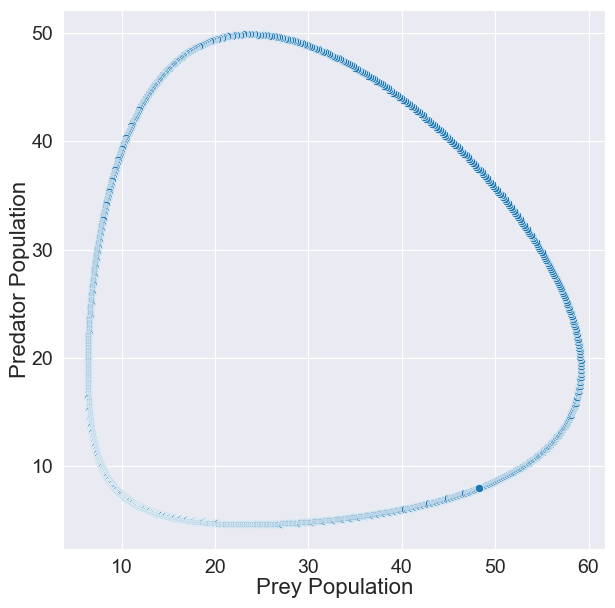

In [2]:
# Parameters from the table
alpha = 4.0e-3    # alpha - prey growth rate
beta = 2.1e-4     # beta - prey death rate
gamma = 4.5e-3    # delta - predator growth rate
delta = 1.9e-4    # gamma - predator death rate

prey_start = 17.0
predator_start = 5.0

# Baseline
LV_P1 = [alpha, beta, delta, gamma,]

LV_PARAM_MINS = 4 * [0.0]
LV_STATE_MINS = 0.1
LV_INIT_STATE = [prey_start, predator_start]

lvm = lotka_volterra.LotkaVolterraModel(
    x0=LV_INIT_STATE,
    lam_true=LV_P1,
    solve_ts=1,
    measurement_noise=1,
    sample_ts=100,
    param_mins=LV_PARAM_MINS,
    state_mins=LV_STATE_MINS,
)

# * Pull synthetic data
lvm.get_data(t0=0.0, tf=2000)

# * Forward solve samples from an initial
pi_in, samples = lvm.get_uniform_initial_samples(num_samples=int(1e3), scale=0.25)
lvm.forward_solve(samples=samples)

# * Plot true, observe, and predicted states
lvm.plot_states()
ax = lvm.plot_true_phase_space()

In [3]:
lvm.samples[0]

lam_0     lam_1     lam_2     lam_3    q_lam_0   q_lam_1    q_lam_2  \
0    0.004042  0.000203  0.000146  0.004207  17.705054  4.946755  24.148245   
1    0.003869  0.000218  0.000181  0.003826  16.836858  4.886660  22.342410   
2    0.003450  0.000229  0.000208  0.003524  17.604344  5.384949  21.917317   
3    0.004051  0.000195  0.000165  0.004010  16.920941  7.113517  22.230790   
4    0.004130  0.000186  0.000181  0.004729  15.619977  4.396598  21.892732   
..        ...       ...       ...       ...        ...       ...        ...   
995  0.004472  0.000172  0.000148  0.004040  17.004591  5.429567  24.361527   
996  0.004899  0.000216  0.000174  0.004675  17.100210  5.862443  24.784034   
997  0.003602  0.000234  0.000174  0.004235  18.042769  5.897798  22.665674   
998  0.004908  0.000192  0.000212  0.004863  16.245969  4.337936  24.512948   
999  0.003638  0.000255  0.000196  0.004768  17.710884  5.528163  22.288053   

      q_lam_3    q_lam_4   q_lam_5  ...   q_lam_32  q_lam_33   q_lam_34  \
0    4.393725  33.135690  4.363708  ...  12.681951  6.230346  16.959426   
1    4.735674  29.574424  5.147437  ...   9.976126  6.532103  12.899341   
2    5.700267  26.908082  6.650350  ...   9.053619  7.120759  10.989658   
3    6.565064  29.328468  6.710230  ...  13.631446  8.067940  17.671721   
4    3.830381  30.851572  3.824790  ...  13.776508  4.760941  19.217030   
..        ...        ...       ...  ...        ...       ...        ...   
995  4.907436  35.020072  5.063173  ...  11.684669  6.711262  16.473209   
996  5.264309  36.052684  5.567851  ...  27.547850  5.245745  39.960278   
997  5.496171  28.572518  5.613964  ...  14.398030  6.862730  17.792676   
998  4.080524  36.864743  4.765048  ...  23.739566  4.072839  35.735597   
999  5.064849  28.191497  5.141300  ...  17.840735  5.504874  22.459998   

     q_lam_35   q_lam_36  q_lam_37   q_lam_38   q_lam_39   q_lam_40   q_lam_41  
0    5.066512  23.091984  4.441856  31.679887   4.331924  43.153001   4.881798  
1    5.468632  16.981980  4.875108  22.537148   4.738939  29.742099   5.163670  
2    6.158226  13.576229  5.581083  16.922544   5.378888  21.046060   5.600366  
3    6.981418  23.253605  6.537728  30.657515   6.813219  39.726729   8.125081  
4    3.983524  27.057911  3.753643  38.041577   4.188030  52.360843   5.854792  
..        ...        ...       ...        ...        ...        ...        ...  
995  5.506228  23.580250  4.929042  33.903277   5.014933  48.127264   6.104369  
996  5.878830  56.146457  8.466758  71.187154  16.234458  68.111838  35.392807  
997  5.939186  22.337807  5.506991  28.163339   5.588951  35.104483   6.334884  
998  4.661804  52.351866  7.228075  69.478803  16.297569  66.018836  44.442290  
999  5.058396  28.406941  5.154285  35.534099   5.972997  42.859510   7.970320  

[1000 rows x 46 columns]

In [4]:
lvm.data[0]

ts  shift_idx  sample_flag  lam_true_0  q_lam_true_0  \
0        0.000000          0         True       0.004     17.000000   
1        1.000500          0        False       0.004     17.050261   
2        2.001001          0        False       0.004     17.100692   
3        3.001501          0        False       0.004     17.151296   
4        4.002001          0        False       0.004     17.202071   
...           ...        ...          ...         ...           ...   
1995  1995.997999          0        False       0.004     47.837517   
1996  1996.998499          0        False       0.004     47.950093   
1997  1997.998999          0        False       0.004     48.062567   
1998  1998.999500          0        False       0.004     48.174934   
1999  2000.000000          0         True       0.004     48.287187   

      q_lam_true_1  q_lam_obs_0  q_lam_obs_1  
0         5.000000    18.037774     4.814643  
1         4.993675          NaN          NaN  
2         4.987405          NaN          NaN  
3         4.981191          NaN          NaN  
4         4.975033          NaN          NaN  
...            ...          ...          ...  
1995      7.842129          NaN          NaN  
1996      7.878303          NaN          NaN  
1997      7.914813          NaN          NaN  
1998      7.951662          NaN          NaN  
1999      7.988853    48.111028     6.021343  

[2000 rows x 8 columns]

# ruttor2009efficient


| parameter | description | true value | percent variation | range | best MUD |
| :---: | :---: | :---: | :---: | :---: | :---: |
| $\alpha$ | prey growth rate | $4 \times 10^{-3}$ | 25% | $(3 \times 10^{-3}, 5 \times 10^{-3})$ | $(4.1 \times 10^{-3})$ |
| $\beta$ | prey death rate | $2 \times 10^{-4}$ | 25% | $(1.5 \times 10^{-4}, 2.5 \times 10^{-4})$ | $(2.2 \times 10^{-4})$ |
| $\gamma$ | predator growth rate | $4 \times 10^{-3}$ | 25% | $(3 \times 10^{-3}, 5 \times 10^{-3})$ | $(4.3 \times 10^{-3})$ |
| $\delta$ | predator death rate | $2 \times 10^{-4}$ | 25% | $(1.5 \times 10^{-4}, 2.5 \times 10^{-4})$ | $(1.8 \times 10^{-4})$ |


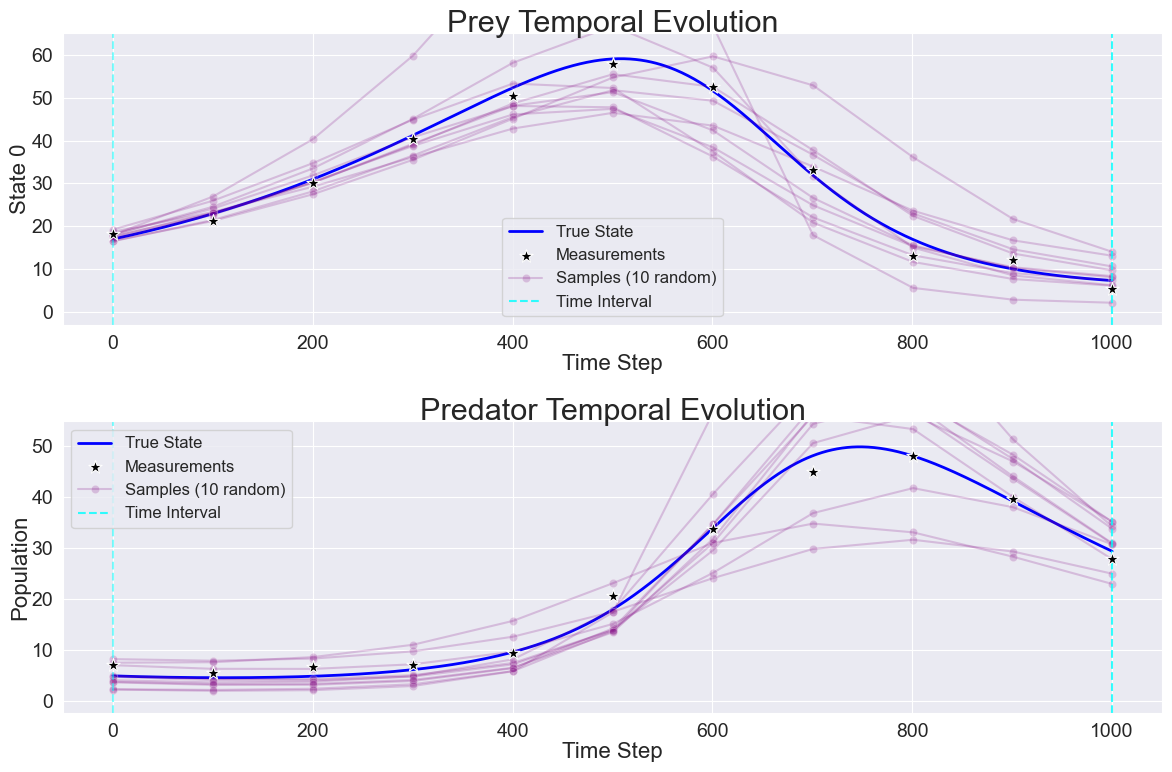

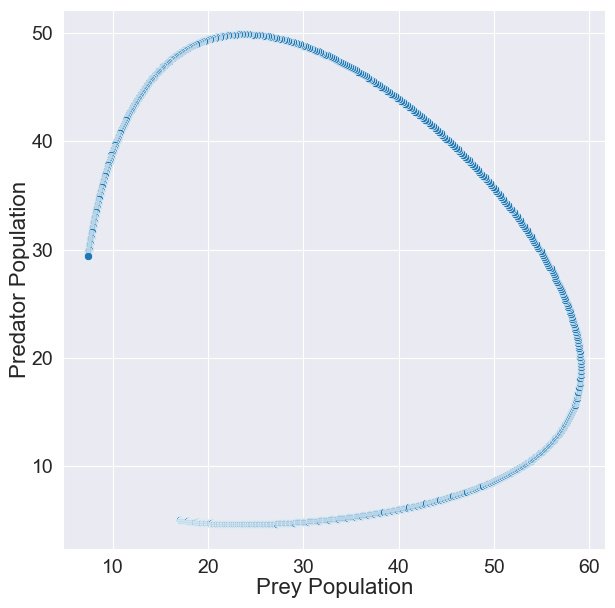

In [5]:
set_seed(21)

num_samples = int(1e3)
diff = 0.1

# Parameters from the table
alpha = 4.0e-3    # alpha - prey growth rate
beta = 2.1e-4     # beta - prey death rate
gamma = 4.5e-3    # delta - predator growth rate
delta = 1.9e-4    # gamma - predator death rate

prey_start = 17.0
predator_start = 5.0

# Baseline
LV_P1_r2009 = [alpha, beta, delta, gamma,]

LV_PARAM_MINS_r2009 = 4 * [0.0]
LV_STATE_MINS_r2009 = 0.1
LV_INIT_STATE_r2009 = [prey_start, predator_start]

lvm_r2009 = lotka_volterra.LotkaVolterraModel(
    x0=LV_INIT_STATE_r2009,
    lam_true=LV_P1_r2009,
    solve_ts=1,
    measurement_noise=2,
    sample_ts=100,
    param_mins=LV_PARAM_MINS_r2009,
    state_mins=LV_STATE_MINS_r2009,
)

# * Pull synthetic data
lvm_r2009.get_data(t0=0.0, tf=1000)

# * Forward solve samples from an initial
pi_in_r2009, samples = lvm_r2009.get_uniform_initial_samples(num_samples=num_samples, scale=diff)
lvm_r2009.forward_solve(samples=samples)

# * Plot true, observe, and predicted states
ax = lvm_r2009.plot_states()
ax = lvm_r2009.plot_true_phase_space()

## Solving using $Q_{PCA}$ Map

[11/19/23 14:07:42] INFO     Logger enabled                                                               ]8;id=662117;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=845865;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 1000                                          │
│ num_params  │ 4                                             │
│ num_qoi     │ 22                                            │
│ num_states  │ 4                                             │
│ mem_usage   │ 290.17 B                                      │
│ solved      │ True                                          │
│ lam_mud     │ [0.00434242 0.00020404 0.00017873 0.00492981] │
│ mud_idx     │ 229                                           │
│ e_r         │ 0.8468600367822539                            │
│ kl          │ 1.667385714823419                             │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

<Axes: xlabel='$\\mathbf{\\lambda}_{3}$', ylabel='Density'>

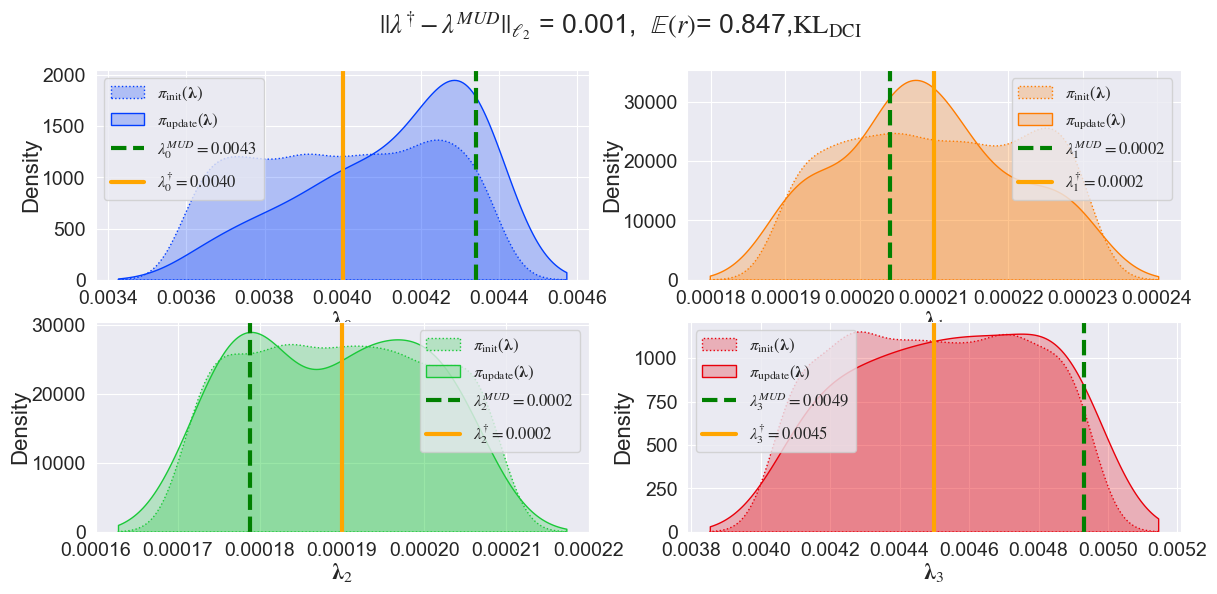

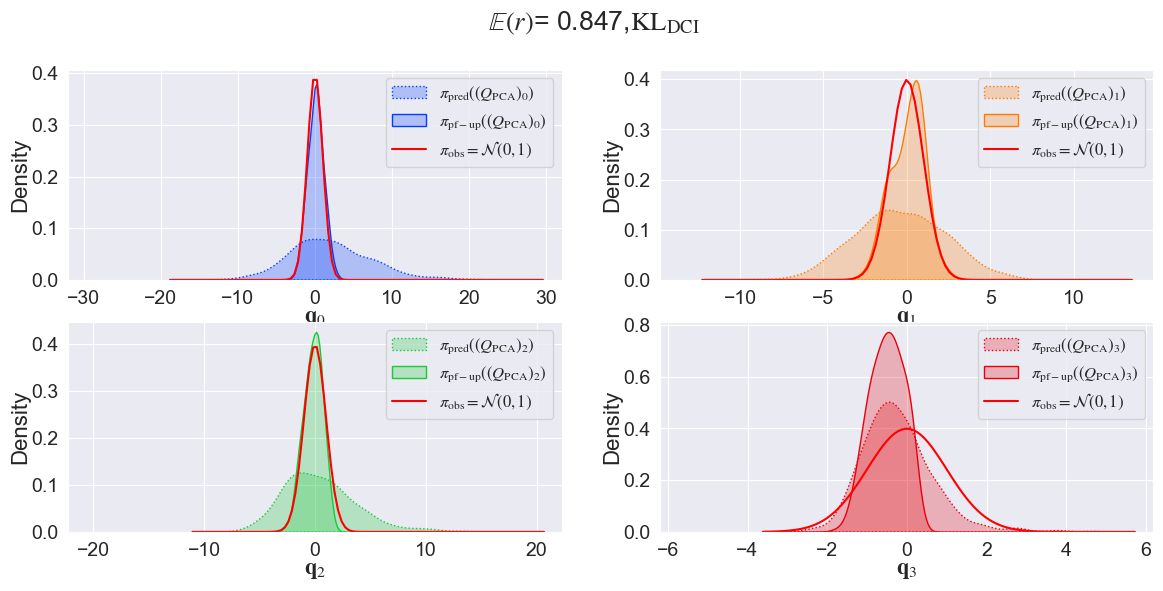

In [6]:
enable_log(level='INFO')

pca_prob = PCAMUDProblem(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)

pca_prob.solve(pca_components=[0, 1, 2], pca_mask=range(9))
print(pca_prob)
axs = pca_prob.param_density_plots(lam_true=LV_P1_r2009)
pca_prob.state_density_plots()
axs

[11/19/23 14:07:43] INFO     Logger enabled                                                               ]8;id=912372;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=616307;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 1000                                          │
│ num_params  │ 4                                             │
│ num_qoi     │ 22                                            │
│ num_states  │ 4                                             │
│ mem_usage   │ 290.17 B                                      │
│ solved      │ True                                          │
│ lam_mud     │ [0.00375794 0.00019313 0.00019096 0.00440136] │
│ mud_idx     │ 250                                           │
│ e_r         │ 1.5783246213825248                            │
│ kl          │ 3.5097426650135337                            │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

<Axes: xlabel='$\\mathbf{\\lambda}_{3}$', ylabel='Density'>

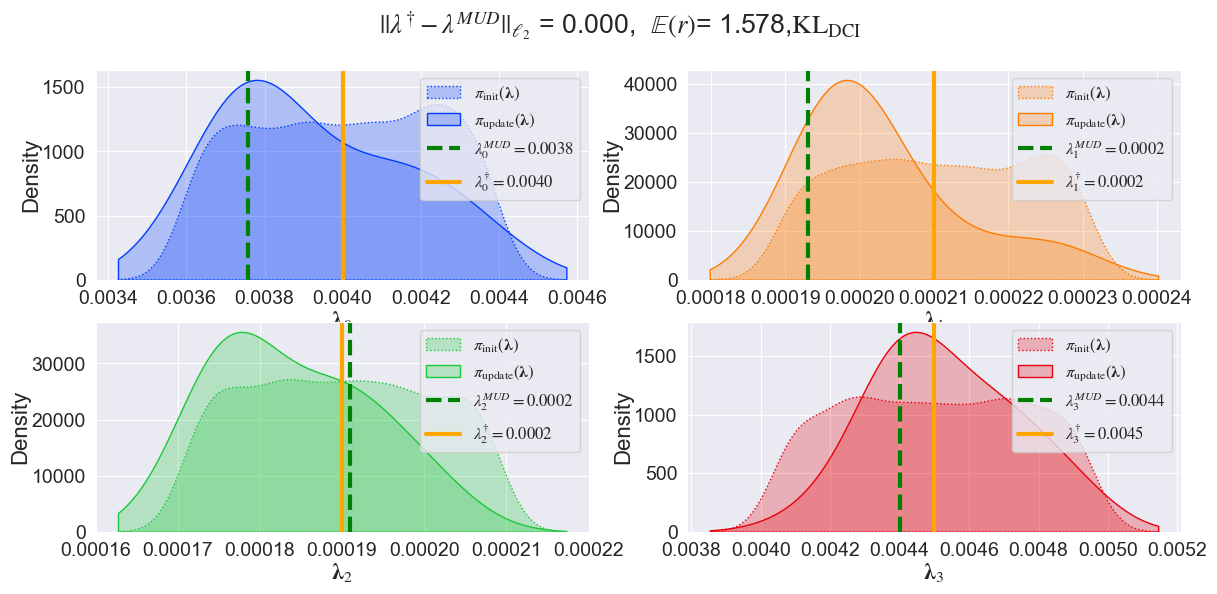

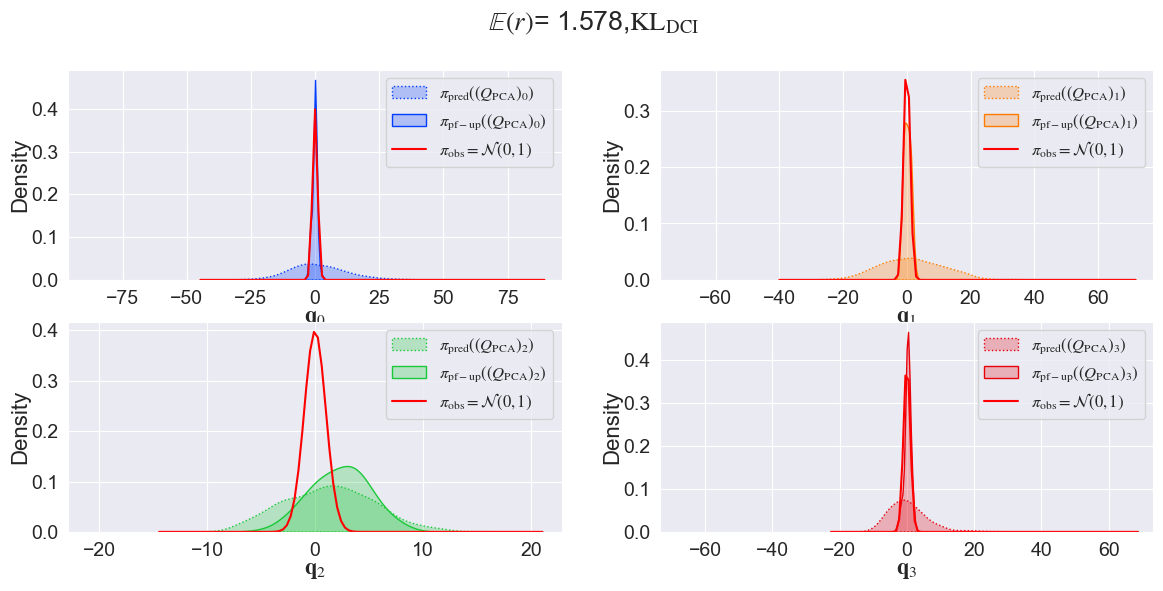

In [7]:
enable_log(level='INFO')

pca_prob = PCAMUDProblem(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)

pca_prob.solve(pca_components=[0, 1, 3], pca_mask=range(pca_prob.n_qoi))
print(pca_prob)
axs = pca_prob.param_density_plots(lam_true=LV_P1_r2009)
pca_prob.state_density_plots()
axs

## Searching for the best solution: Offline Sequential Search

[11/19/23 14:07:45] INFO     Searching through combinations:                         ]8;id=402480;file:///Users/cnegrete/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py\OfflineSequentialSearch.py]8;;\:]8;id=137528;file:///Users/cnegrete/repos/pyDCI/src/pydci/consistent_bayes/OfflineSequentialSearch.py#172\172]8;;\
                                   exp_thresh  pca_components  \                                                   
                             0   1.000000e+10               1                                                      
                             1   1.000000e+10               1                                                      
                             2   1.000000e+10               1                                                      
                             3   1.000000e+10               1                                                      
                             4   1.000000e+10               1                                                      
                             5   1.000000e+10               1                                                      
                             6   1.000000e+10               1                                                      
                             7   1.000000e+10               1                                                      
                             8   1.000000e+10               2                                                      
                             9   1.000000e+10               2                                                      
                             10  1.000000e+10               2                                                      
                             11  1.000000e+10               2                                                      
                             12  1.000000e+10               2                                                      
                             13  1.000000e+10               2                                                      
                             14  1.000000e+10               2                                                      
                             15  1.000000e+10               2                                                      
                             16  1.000000e+10               3                                                      
                             17  1.000000e+10               3                                                      
                             18  1.000000e+10               3                                                      
                             19  1.000000e+10               3                                                      
                                                                                                                   
                                                                          pca_mask                                 
                             pca_splits                                                                            
                             0                                        (0, 1, 2, 3)                                 
                             1                                                                                     
                             1                                  (0, 1, 2, 3, 4, 5)                                 
                             1                                                                                     
                             2                            (0, 1, 2, 3, 4, 5, 6, 7)                                 
                             1                                                                                     
                             3                      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)                                 
                             1                                

[<Axes: xlabel='Number of Data Points Used', ylabel='Relative $\\ell_2$ Error'>,
 <Axes: xlabel='Number of Data Points Used', ylabel='$\\mathbb{E}(r)$'>,
 <Axes: xlabel='Number of Data Points Used', ylabel='$\\mathrm{KL}_{\\mathrm{DCI}}$'>]

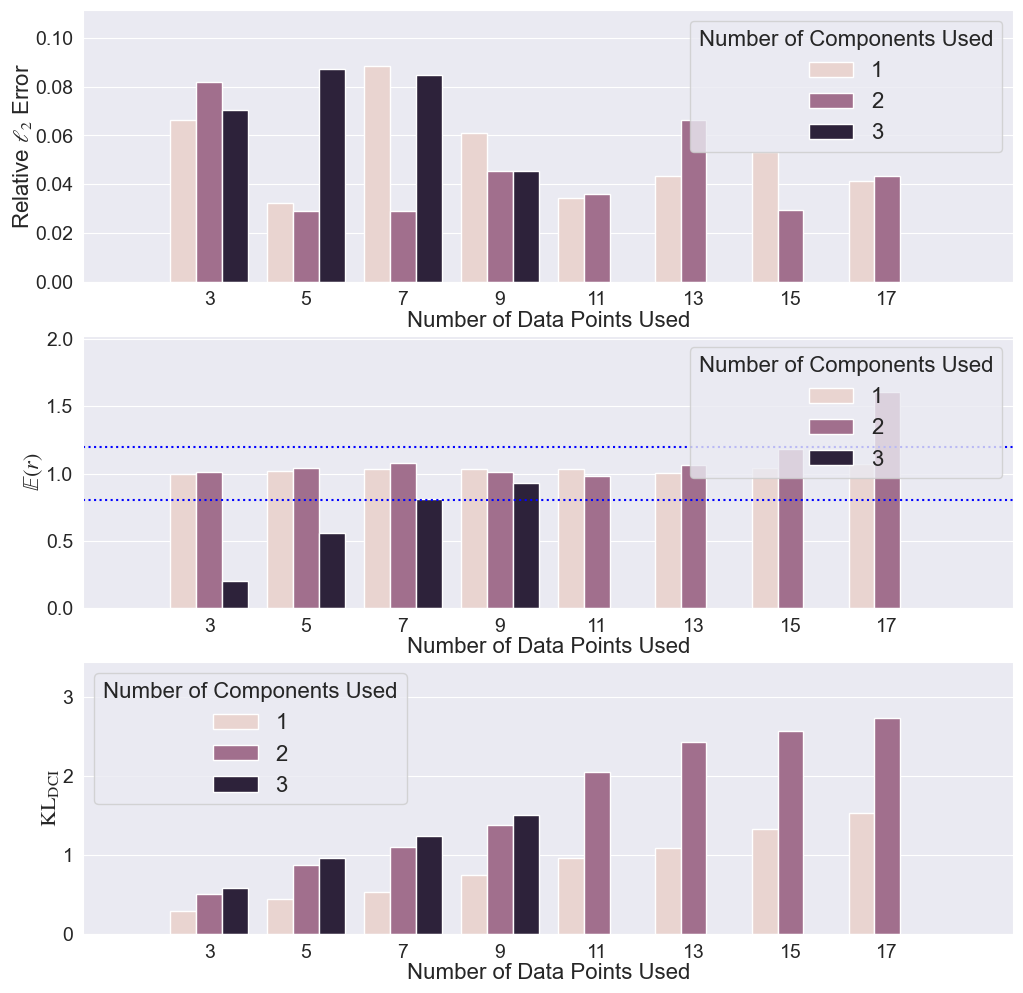

In [8]:
search_params = dict(
    max_nc=5,
    split_range=range(1, 2),
    mask_range=range(4, 20, 2),
    best_method='max_kl',
    exp_thresh=0.3,
)

# enable_log(level='INFO')
# disable_log()
oss_r2009 = OfflineSequentialSearch(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)
oss_r2009.solve(**search_params)
oss_r2009.summary_barplots_by_num_data(LV_P1_r2009)

In [9]:
# select pca_mask = 'range(0, 9)' and pca_mask='[0, 1, 2]' in oss_r2009.results
selected_rows = oss_r2009.results[(oss_r2009.results['Number of Data Points Used'] == 7) & (oss_r2009.results['Number of Components Used'] == 2)]
selected_rows

e_r        kl  k_eff  k_eff_up  solved error  lam_MUD_0  lam_MUD_1  \
0  1.076242  1.101687    1.0     0.909    True  None   0.004139   0.000207   

   lam_MUD_2  lam_MUD_3  ...  search_index predict_delta within_thresh  valid  \
0   0.000201   0.004607  ...            10      0.076242          True   True   

   closest  max_kl  min_kl  Number of Data Points Used  \
0    False   False   False                           7   

   Number of Components Used   l2_err  
0                          2  0.02912  

[1 rows x 25 columns]

<Axes: title={'center': '$\\lambda_3$'}, xlabel='$\\mathbf{\\lambda}_{3}$', ylabel='Density'>

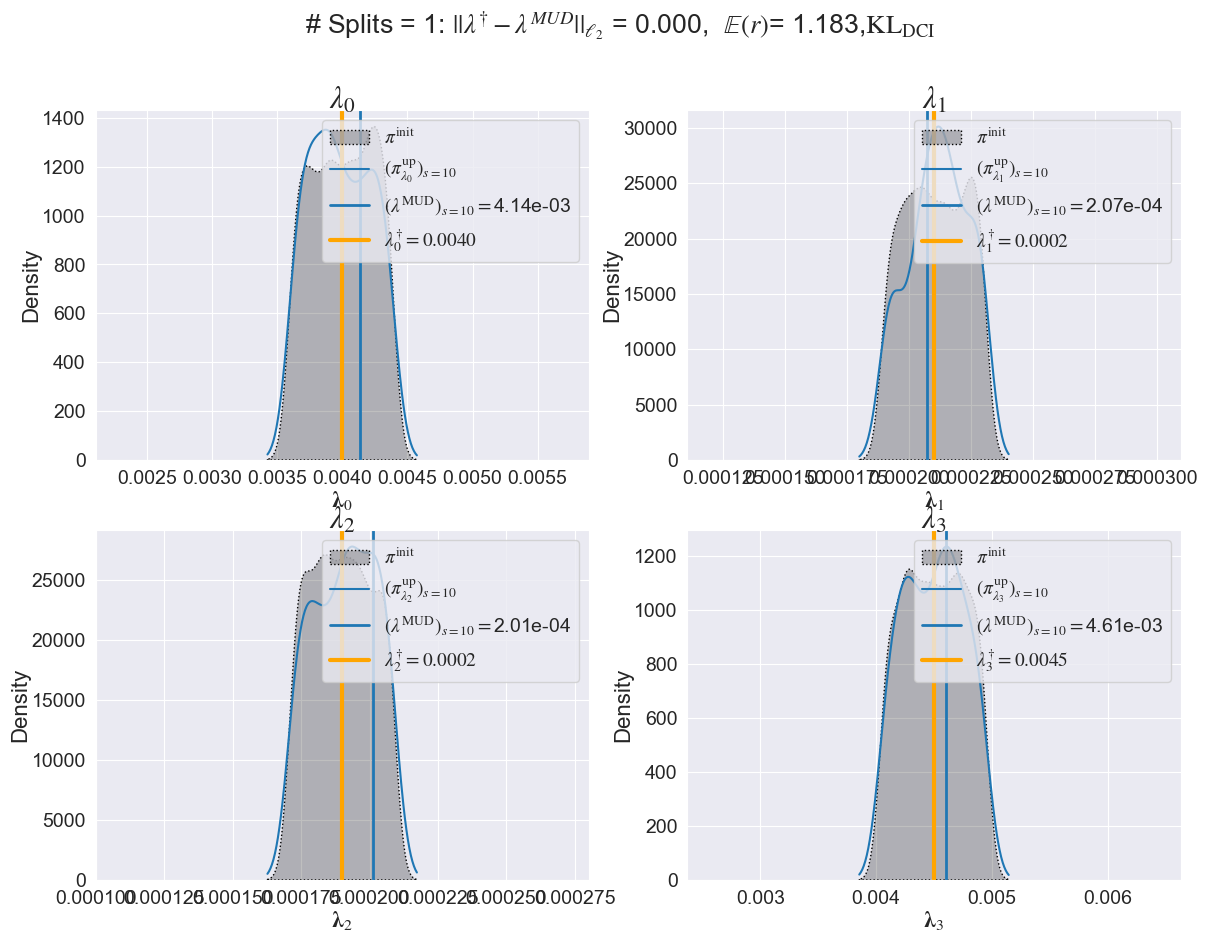

In [10]:
oss_r2009.param_density_plots(search_idxs=selected_rows.search_index, lam_true=LV_P1_r2009)

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

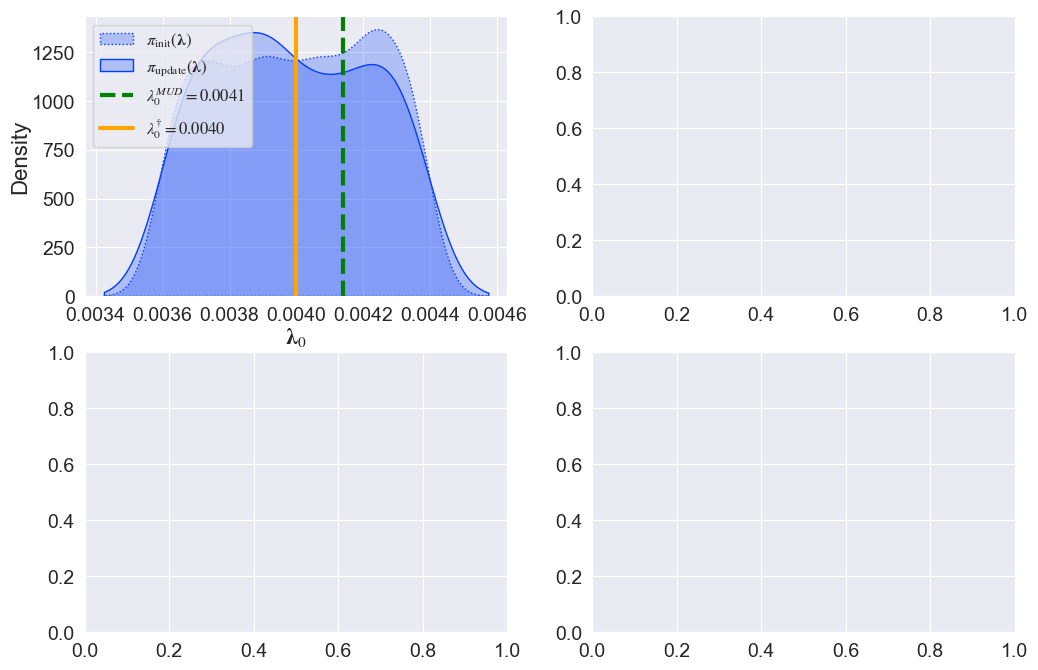

In [11]:
ax = oss_r2009.probs[selected_rows['search_index'].values[0]].param_density_plots(lam_true=LV_P1_r2009)
ax

## Repeated Trials

Now lets repeat the experiment for

In [ ]:
n_trials = 5
num_samples = int(1e4)
# n_trials = 10
# num_samples = int(1e4)
search_params = dict(
    max_nc=5,
    split_range=range(1, 2),
    mask_range=range(4, 20, 2),
    best_method='max_kl',
    exp_thresh=0.3,
)

# enable_log(level='INFO')
disable_log()
trial_results = []
for i in range(n_trials):
    lvm_r2009 = lotka_volterra.LotkaVolterraModel(
        x0=LV_INIT_STATE_r2009,
        lam_true=LV_P1_r2009,
        solve_ts=1,
        measurement_noise=2,
        sample_ts=100,
        param_mins=LV_PARAM_MINS_r2009,
        state_mins=LV_STATE_MINS_r2009,
    )

    # * Pull synthetic data
    lvm_r2009.get_data(t0=0.0, tf=2000)

    # * Forward solve samples from an initial
    pi_in_r2009, samples = lvm_r2009.get_uniform_initial_samples(num_samples=num_samples, scale=0.25)
    lvm_r2009.forward_solve(samples=samples)

    logger.info(f'Iteration {i}')
    oss_r2009 = OfflineSequentialSearch(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)
    oss_r2009.solve(**search_params)
    trial_results.append(oss_r2009.results)

trial_results = oss_r2009.process_results(LV_P1_r2009, results_df=pd.concat(trial_results))
trial_results

Solving model sample set: |                    | ▁▃▅ 0/10000 [0%] in 0s (~0s, 0.

[11/19/23 14:03:48] INFO     Iteration 0                                                           ]8;id=648259;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py\2096988606.py]8;;\:]8;id=671116;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py#34\34]8;;\

[11/19/23 14:04:05] INFO     Iteration 1                                                           ]8;id=574798;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py\2096988606.py]8;;\:]8;id=437885;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py#34\34]8;;\

[11/19/23 14:04:22] INFO     Iteration 2                                                           ]8;id=206965;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py\2096988606.py]8;;\:]8;id=358838;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py#34\34]8;;\

[11/19/23 14:04:39] INFO     Iteration 3                                                           ]8;id=479375;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py\2096988606.py]8;;\:]8;id=138690;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py#34\34]8;;\

[11/19/23 14:04:56] INFO     Iteration 4                                                           ]8;id=510259;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py\2096988606.py]8;;\:]8;id=179966;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_189/2096988606.py#34\34]8;;\

e_r        kl  k_eff  k_eff_up  solved error  lam_MUD_0  lam_MUD_1  \
0   1.003001  0.267188    1.0    1.0000    True  None   0.003064   0.000163   
0   1.009361  0.411241    1.0    0.9870    True  None   0.003981   0.000187   
0   1.015446  0.684487    1.0    0.8817    True  None   0.003467   0.000194   
0   1.007856  0.989324    1.0    0.7329    True  None   0.004189   0.000244   
0   1.022037  1.334386    1.0    0.5796    True  None   0.004472   0.000181   
..       ...       ...    ...       ...     ...   ...        ...        ...   
0   0.985172  3.982263    1.0    0.1063    True  None   0.003584   0.000200   
0   0.494817  0.491440    1.0    0.9998    True  None   0.004963   0.000164   
0   0.768445  1.049352    1.0    0.9653    True  None   0.004964   0.000161   
0   1.019089  1.534513    1.0    0.7991    True  None   0.004902   0.000159   
0   1.060724  2.177638    1.0    0.5782    True  None   0.004676   0.000242   

    lam_MUD_2  lam_MUD_3  ...  search_index predict_delta within_thresh  \
0    0.000188   0.003511  ...             0      0.003001          True   
0    0.000175   0.003531  ...             1      0.009361          True   
0    0.000175   0.004828  ...             2      0.015446          True   
0    0.000223   0.004678  ...             3      0.007856          True   
0    0.000214   0.003412  ...             4      0.022037          True   
..        ...        ...  ...           ...           ...           ...   
0    0.000184   0.003389  ...            15      0.014828          True   
0    0.000178   0.004098  ...            16      0.505183         False   
0    0.000222   0.005164  ...            17      0.231555          True   
0    0.000167   0.003401  ...            18      0.019089          True   
0    0.000157   0.005039  ...            19      0.060724          True   

    valid  closest  max_kl  min_kl  Number of Data Points Used  \
0    True     True   False    True                           3   
0    True    False   False   False                           5   
0    True    False   False   False                           7   
0    True    False   False   False                           9   
0    True    False   False   False                          11   
..    ...      ...     ...     ...                         ...   
0    True    False    True   False                          17   
0   False    False   False   False                           3   
0    True    False   False   False                           5   
0    True    False   False   False                           7   
0    True    False   False   False                           9   

    Number of Components Used    l2_err  
0                           1  0.226020  
0                           1  0.160900  
0                           1  0.103831  
0                           1  0.043753  
0                           1  0.196803  
..                        ...       ...  
0                           2  0.196870  
0                           3  0.173343  
0                           3  0.194417  
0                           3  0.236057  
0                           3  0.143641  

[100 rows x 25 columns]

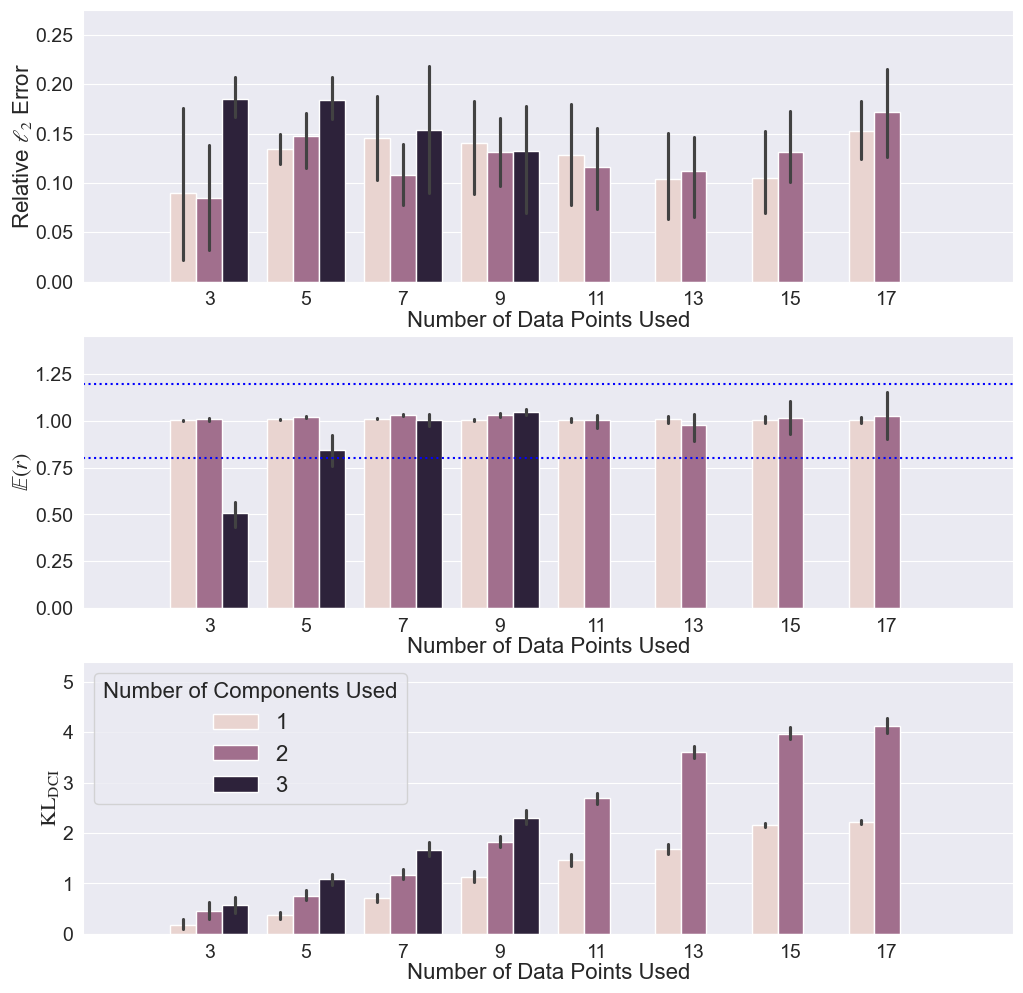

In [ ]:
ax = oss_r2009.summary_barplots_by_num_data(LV_P1_r2009, results_df=trial_results)
ax[0].get_legend().remove()
ax[1].get_legend().remove()

### Best Solution

                        OfflineSequential                         
┌────────────────┬───────────────────────────────────────────────┐
│ num_samples    │ 10000                                         │
│ num_params     │ 4                                             │
│ num_qoi        │ 42                                            │
│ num_states     │ 4                                             │
│ num_iter       │ 1                                             │
│ mem_usage      │ 4.36 KB                                       │
│ solved         │ True                                          │
│ pca_components │ [0, 1]                                        │
│ pca_mask       │ range(0, 18)                                  │
│ lam_mud        │ [0.00358354 0.00019955 0.00018354 0.00338892] │
│ mud_idx        │ 6012                                          │
│ e_r            │ 0.9851722334811902                            │
│ kl             │ 3.9822627805096107                            │
│ error          │ None                                          │
└────────────────┴───────────────────────────────────────────────┘

<Axes: title={'center': '$\\lambda_3$'}, xlabel='$\\mathbf{\\lambda}_{3}$', ylabel='Density'>

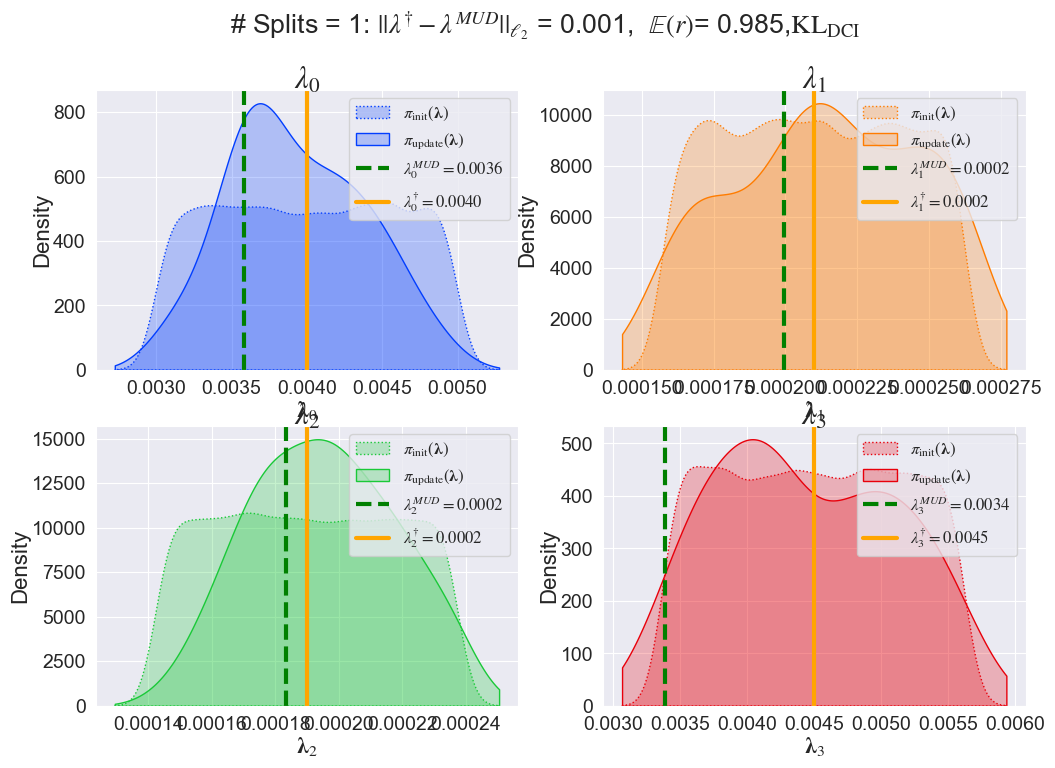

In [ ]:
print(oss_r2009.best)
ax = oss_r2009.best.param_density_plots(lam_true=LV_P1_r2009)

ax

### Particular Solutions

Lets try out some of these solutions

[11/19/23 14:05:11] INFO     Logger enabled                                                               ]8;id=318688;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=965491;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 10000                                         │
│ num_params  │ 4                                             │
│ num_qoi     │ 42                                            │
│ num_states  │ 4                                             │
│ mem_usage   │ 4.36 KB                                       │
│ solved      │ True                                          │
│ lam_mud     │ [0.00467631 0.00024232 0.00015728 0.00503859] │
│ mud_idx     │ 4685                                          │
│ e_r         │ 1.0607235676176094                            │
│ kl          │ 2.1776375701825774                            │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

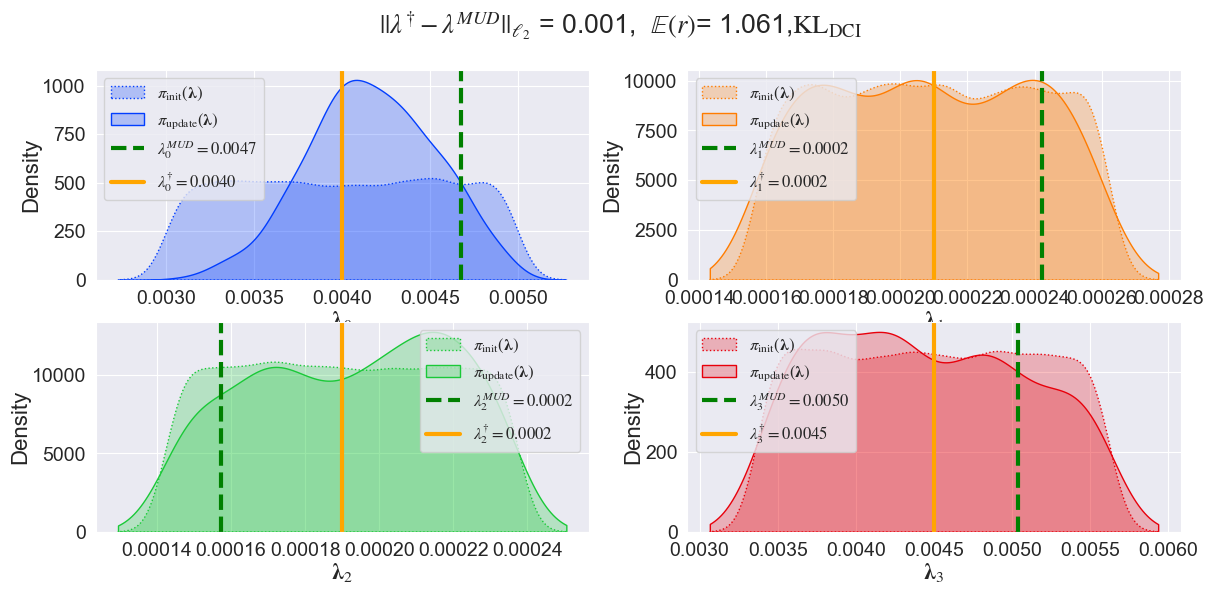

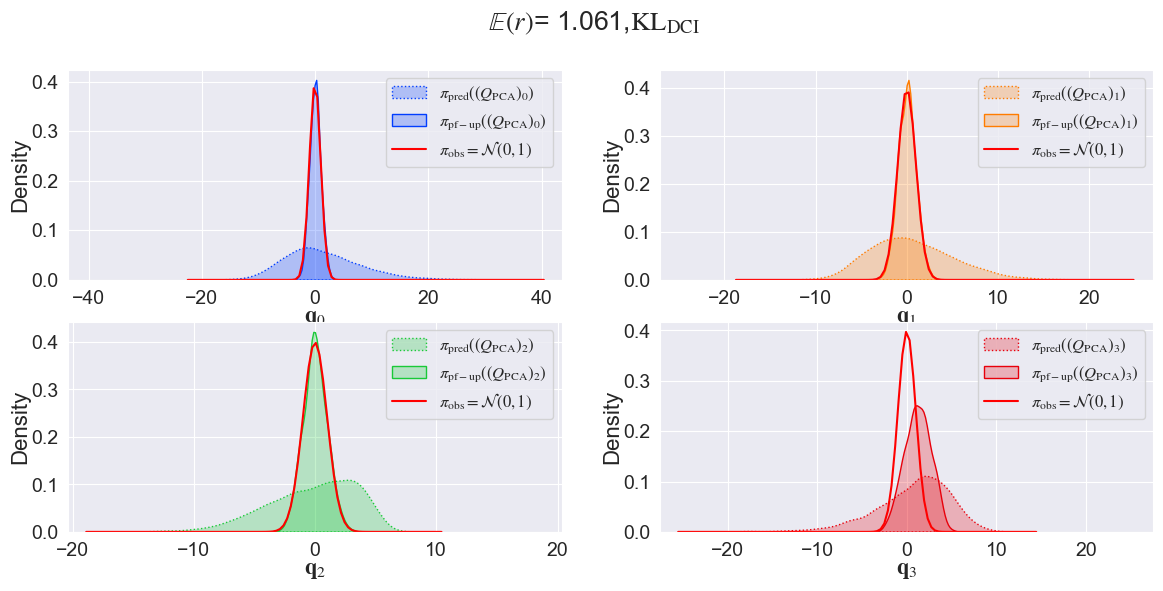

In [ ]:
enable_log(level='INFO')

pca_prob_r2009 = PCAMUDProblem(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)

pca_prob_r2009.solve(pca_components=[0, 1, 2], pca_mask=range(10))
print(pca_prob_r2009)
pca_prob_r2009.param_density_plots(lam_true=LV_P1_r2009)
pca_prob_r2009.state_density_plots()

[11/19/23 14:00:47] INFO     Logger enabled                                                               ]8;id=659569;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=532723;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 10000                                         │
│ num_params  │ 4                                             │
│ num_qoi     │ 42                                            │
│ num_states  │ 4                                             │
│ mem_usage   │ 4.36 KB                                       │
│ solved      │ True                                          │
│ lam_mud     │ [0.00361508 0.00020862 0.0002198  0.00479355] │
│ mud_idx     │ 6478                                          │
│ e_r         │ 0.9339684621509529                            │
│ kl          │ 3.9993264513263878                            │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

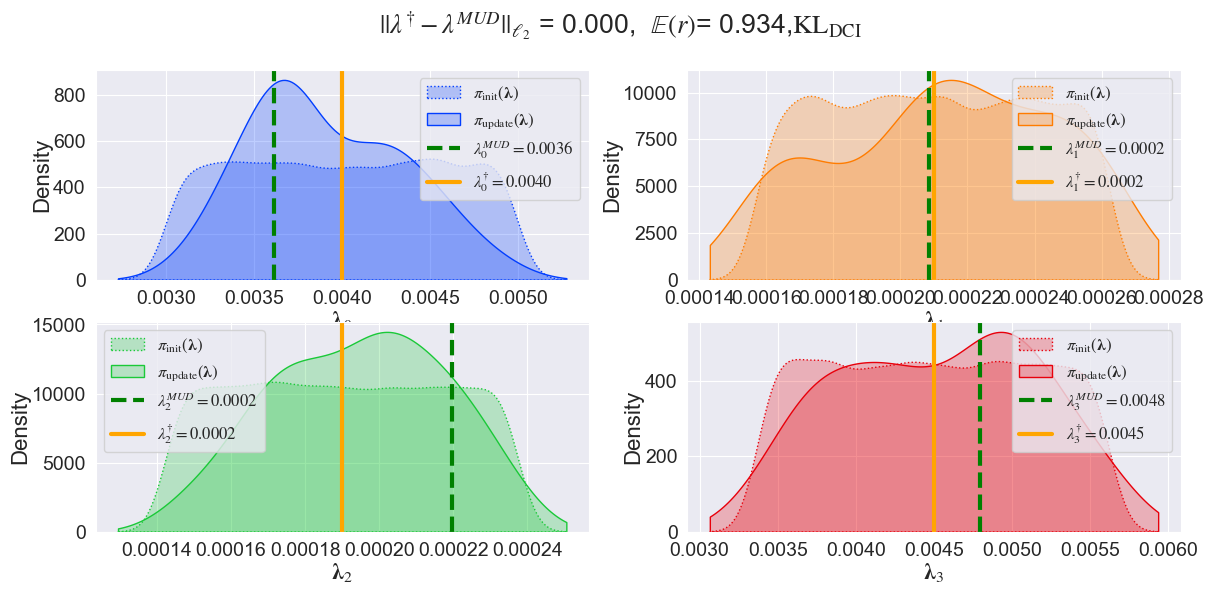

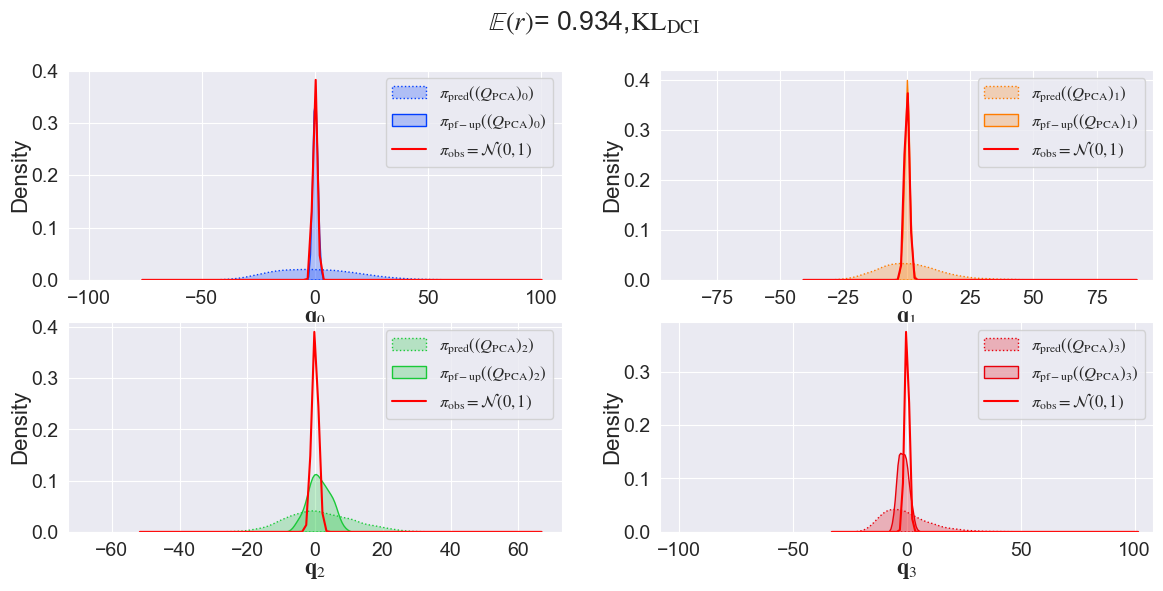

In [ ]:
enable_log(level='INFO')

pca_prob_r2009 = PCAMUDProblem(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)

pca_prob_r2009.solve(pca_components=[0, 1], pca_mask=range(17))
print(pca_prob_r2009)
pca_prob_r2009.param_density_plots(lam_true=LV_P1_r2009)
pca_prob_r2009.state_density_plots()

### Alternating QoI

[11/19/23 13:20:07] INFO     Logger enabled                                                               ]8;id=754419;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=209496;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 1000                                          │
│ num_params  │ 4                                             │
│ num_qoi     │ 42                                            │
│ num_states  │ 4                                             │
│ mem_usage   │ 446.42 B                                      │
│ solved      │ True                                          │
│ lam_mud     │ [0.00400824 0.00025913 0.00015544 0.00358876] │
│ mud_idx     │ 755                                           │
│ e_r         │ 0.7594842102703238                            │
│ kl          │ 4.1058606596684575                            │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

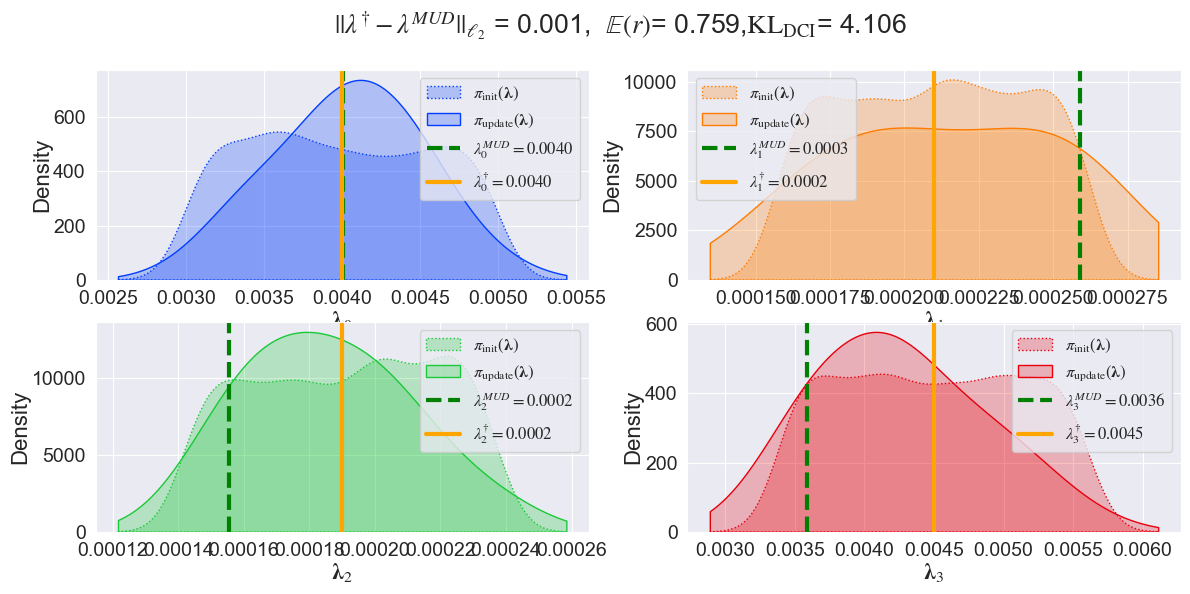

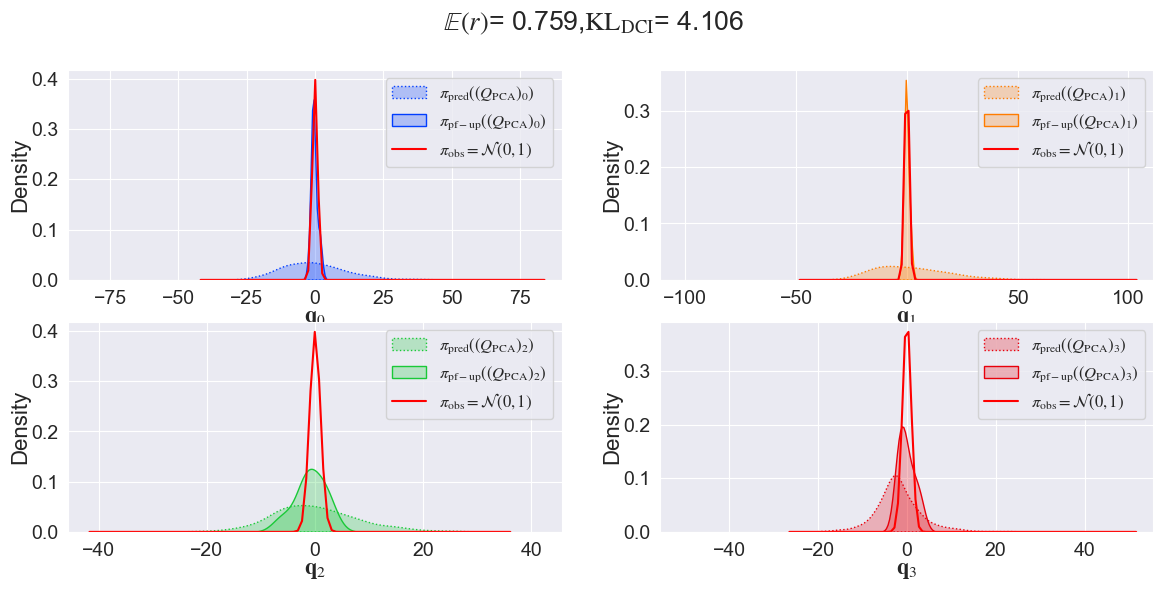

In [ ]:
enable_log(level='INFO')

pca_prob_r2009 = PCAMUDProblem(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)

pca_prob_r2009.solve(pca_components=[0, 1], pca_mask=range(0, 17, 2))
print(pca_prob_r2009)
pca_prob_r2009.param_density_plots(lam_true=LV_P1_r2009)
pca_prob_r2009.state_density_plots()

[11/19/23 13:20:08] INFO     Logger enabled                                                               ]8;id=359606;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=981365;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 1000                                          │
│ num_params  │ 4                                             │
│ num_qoi     │ 42                                            │
│ num_states  │ 4                                             │
│ mem_usage   │ 446.42 B                                      │
│ solved      │ True                                          │
│ lam_mud     │ [0.00395712 0.00022556 0.00020542 0.00420052] │
│ mud_idx     │ 303                                           │
│ e_r         │ 0.8272431832985426                            │
│ kl          │ 2.870981784868304                             │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

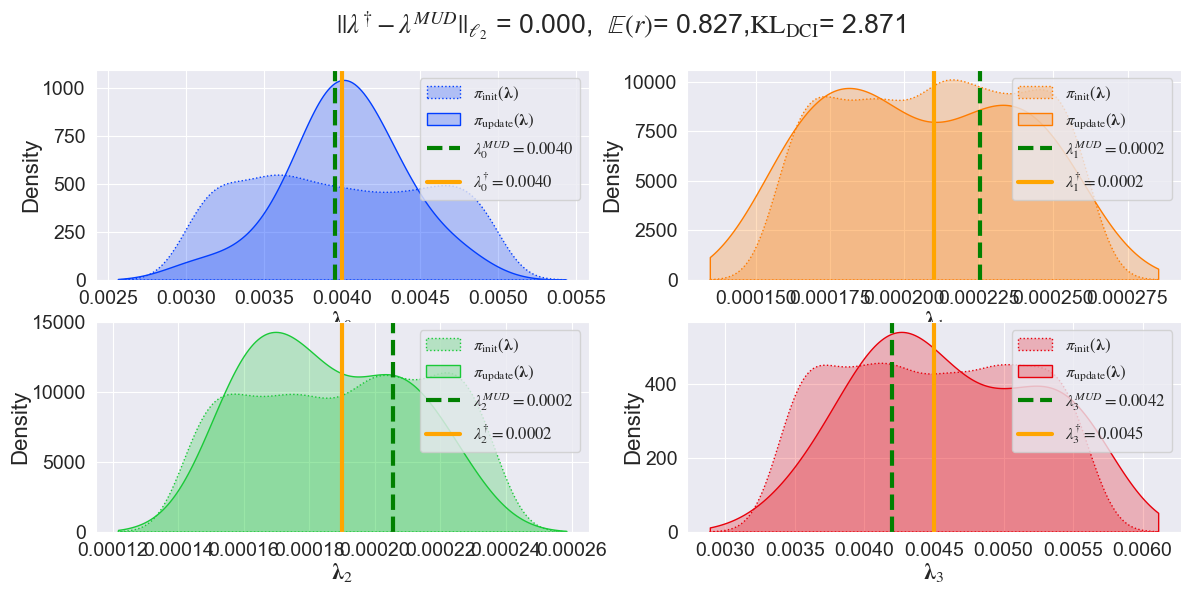

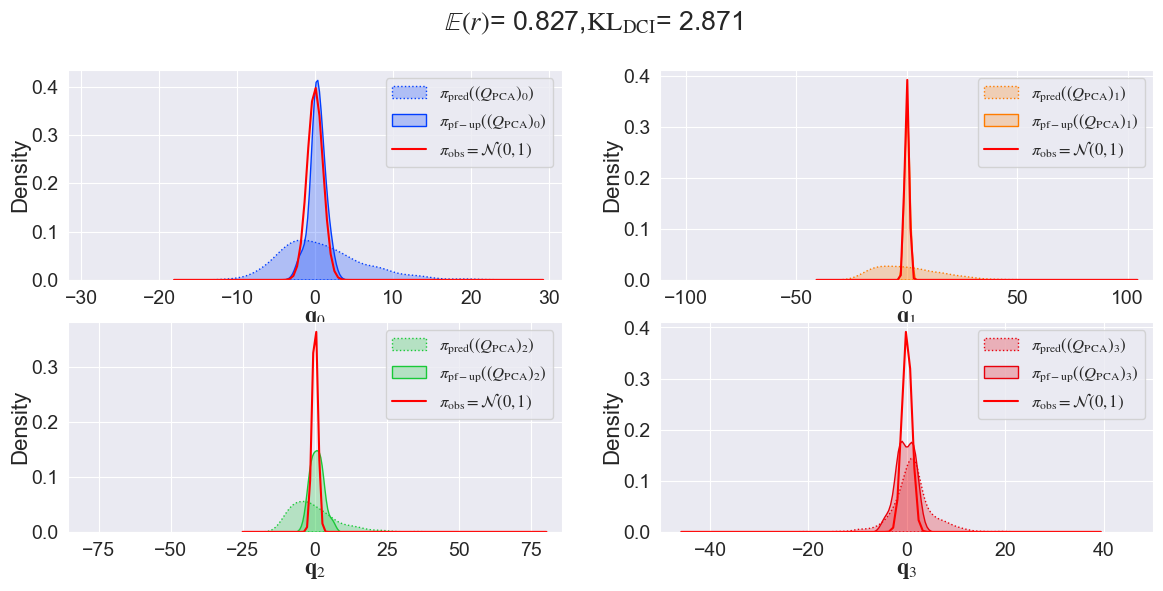

In [ ]:
enable_log(level='INFO')

pca_prob_r2009 = PCAMUDProblem(lvm_r2009.samples[0], lvm_r2009.data[0], lvm_r2009.measurement_noise, pi_in=pi_in_r2009)

pca_prob_r2009.solve(pca_components=[0, 1], pca_mask=range(1, 17, 2))
print(pca_prob_r2009)
pca_prob_r2009.param_density_plots(lam_true=LV_P1_r2009)
pca_prob_r2009.state_density_plots()

In [ ]:
# def process_results(self, lam_true = None, e_r_thresh= 0.2, results_df=None) -> None:
#     # TODO: Create a make_readable results method
#     results = self.results if results_df is None else results_df
#     x_label = 'Number of Data Points Used'
#     num_data = [eval(x)[-1] for x in results['pca_mask']]
#     results[x_label] = num_data
# 
#     group_label = 'Number of Components Used'
#     num_components = [len(eval(x)) for x in results['pca_components']]
#     results[group_label] = num_components
# 
#     if lam_true is not None:
#         results.loc[:,'l2_err']  = self.get_l2_error(lam_true, results_df=results_df)
#     
#     return results
    
results = oss_r2009.process_results(lam_true=LV_P1_r2009, results_df=results)
results

e_r        kl  k_eff  k_eff_up  solved error  lam_MUD_0  lam_MUD_1  \
0   1.003481  0.370428    1.0     1.000    True  None   0.003100   0.000189   
0   1.015663  0.528093    1.0     0.986    True  None   0.003091   0.000227   
0   1.051520  0.678925    1.0     0.904    True  None   0.003275   0.000167   
0   1.056607  0.996641    1.0     0.747    True  None   0.003725   0.000204   
0   0.979361  1.269851    1.0     0.591    True  None   0.003960   0.000248   
..       ...       ...    ...       ...     ...   ...        ...        ...   
0   0.500211  4.500983    1.0     0.097    True  None   0.003814   0.000241   
0   0.183537  0.582750    1.0     0.999    True  None   0.003076   0.000257   
0   0.561281  1.081261    1.0     0.961    True  None   0.003032   0.000233   
0   0.905221  1.625410    1.0     0.790    True  None   0.003085   0.000190   
0   1.202268  2.289605    1.0     0.562    True  None   0.003879   0.000261   

    lam_MUD_2  lam_MUD_3  ...  search_index predict_delta within_thresh  \
0    0.000228   0.003678  ...             0      0.003481          True   
0    0.000218   0.004915  ...             1      0.015663          True   
0    0.000172   0.004420  ...             2      0.051520          True   
0    0.000168   0.005594  ...             3      0.056607          True   
0    0.000153   0.004123  ...             4      0.020639          True   
..        ...        ...  ...           ...           ...           ...   
0    0.000207   0.004939  ...            15      0.499789         False   
0    0.000236   0.004095  ...            16      0.816463         False   
0    0.000221   0.004427  ...            17      0.438719         False   
0    0.000143   0.004994  ...            18      0.094779          True   
0    0.000148   0.003511  ...            19      0.202268          True   

    valid  closest  max_kl  min_kl  Number of Data Points Used  \
0    True     True   False    True                           3   
0    True    False   False   False                           5   
0    True    False   False   False                           7   
0    True    False   False   False                           9   
0    True    False   False   False                          11   
..    ...      ...     ...     ...                         ...   
0   False    False   False   False                          17   
0   False    False   False   False                           3   
0   False    False   False   False                           5   
0    True    False   False   False                           7   
0    True    False   False   False                           9   

    Number of Components Used    l2_err  
0                           1  0.202257  
0                           1  0.165973  
0                           1  0.121297  
0                           1  0.187251  
0                           1  0.063486  
..                        ...       ...  
0                           2  0.079335  
0                           3  0.167751  
0                           3  0.161226  
0                           3  0.172627  
0                           3  0.165606  

[100 rows x 25 columns]

In [10]:
oss_r2009.summary_barplots_by_num_data(LV_P1_r2009, df=results)

NameError: name 'results' is not defined

In [11]:
# select pca_mask = 'range(0, 9)' and pca_mask='[0, 1, 2]' in oss_r2009.results
selected_rows = oss_r2009.results[(oss_r2009.results['Number of Data Points Used'] == 15) & (oss_r2009.results['Number of Components Used'] == 3)]
selected_rows

Empty DataFrame
Columns: [e_r, kl, k_eff, k_eff_up, solved, error, lam_MUD_0, lam_MUD_1, lam_MUD_2, lam_MUD_3, MUD_idx, pca_components, pca_mask, i, I, search_index, predict_delta, within_thresh, valid, closest, max_kl, min_kl, Number of Data Points Used, Number of Components Used, l2_err]
Index: []

[0 rows x 25 columns]

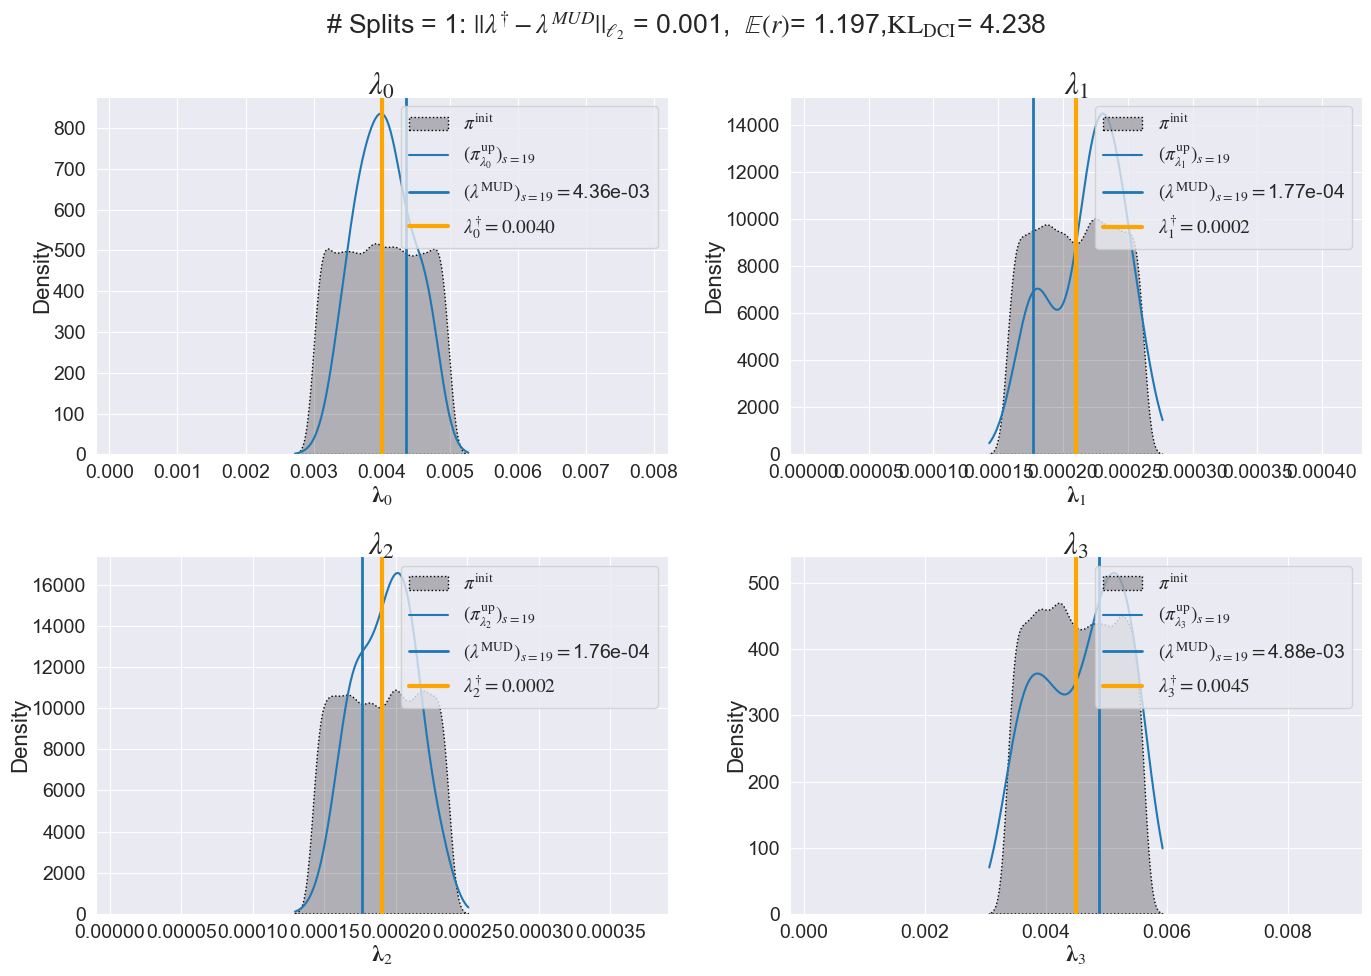

In [ ]:
oss_r2009.param_density_plots(search_idxs=selected_rows.search_index, lam_true=LV_P1_r2009)

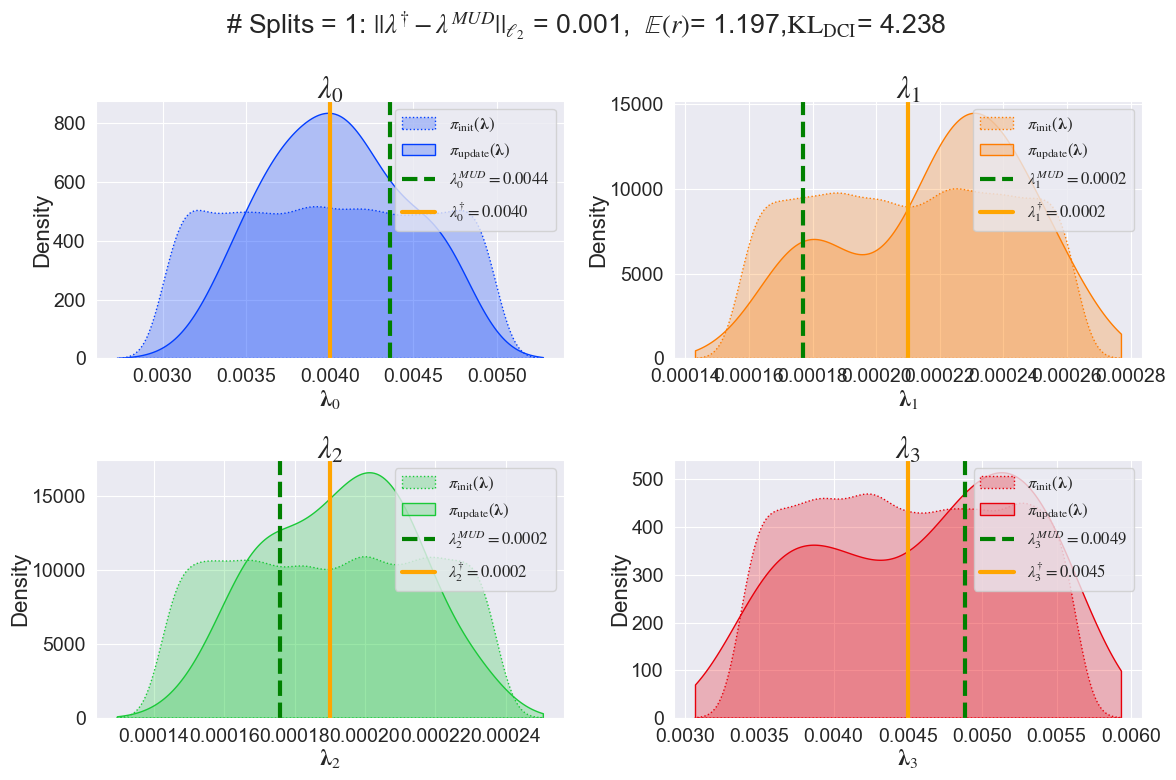

In [ ]:
oss_r2009.probs[selected_rows['search_index'].values[0]].param_density_plots(lam_true=LV_P1_r2009)

# Parameters from butler2020optimal

| parameter | description | true value | percent variation | range | best MUD |
| --- | --- | --- | --- | --- | --- |
| alpha | prey growth rate | 1.0 | 25.0% | (0.75, 1.25) | 1.0 |
| beta | prey death rate | 0.02 | 2.0% | (0.015, 0.025) | 0.02 |
| gamma | predator growth rate | 1.0 | 0.0% | (0.75, 1.25) | 1.0 |
| delta | predator death rate | 0.03 | 0.0% | (0.0225, 0.0375) | 0.03 |

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from pydci.log import enable_log, disable_log
from pydci.examples import lotka_volterra
import importlib
import itertools

from pydci import OfflineSequentialSearch, PCAMUDProblem
from pydci.log import enable_log, disable_log, logger
from pydci.examples import lotka_volterra
from pydci.utils import set_seed
from pydci.plotting import create_legend

sns.set_style('whitegrid', {'axes.grid': False})

set_seed(2023)

num_samples = int(1e4)
diff = 0.25              
tf = 14
noise = 10
sample_ts = 0.1
solve_ts = 0.01

# Parameters from the table
alpha = 1.0    # alpha - prey growth rate
beta = 0.02    # beta - prey death rate
gamma = 1.00   # delta - predator growth rate
delta = 0.03    # gamma - predator death rate


# Set each title to the param: short explanation for each lam_i in ax
param_titles ={
    0:rf'$\alpha$ - prey growth rate',
    1:rf'$\beta$ - prey death rate',
    2:rf'$\gamma$ - predator growth rate',
    3:rf'$\delta$ - predator death rate'
    }

# Initial Conditions
prey_start = 100
predator_start = 10

# Baseline
LV_P1_b2020 = [alpha, beta, delta, gamma]

LV_PARAM_MINS_b2020 = 4 * [0.0]
LV_STATE_MINS_b2020 = 2
LV_INIT_STATE_b2020 = [prey_start, predator_start]

search_params = dict(
    max_nc=5,
    split_range=range(1, 2),
    mask_range=[10, 20, 50, 100],
    best_method='max_kl',
    exp_thresh=0.3,
)

lvm_b2020 = lotka_volterra.LotkaVolterraModel(
    x0=LV_INIT_STATE_b2020,
    lam_true=LV_P1_b2020,
    solve_ts=solve_ts,
    measurement_noise=noise,
    sample_ts=sample_ts,
    param_mins=LV_PARAM_MINS_b2020,
    state_mins=LV_STATE_MINS_b2020,
)

# * Pull synthetic data
lvm_b2020.get_data(t0=0.0, tf=5)

# * Forward solve samples from an initial
pi_in_b2020, samples = lvm_b2020.get_uniform_initial_samples(num_samples=num_samples, scale=diff)
lvm_b2020.forward_solve(samples=samples)

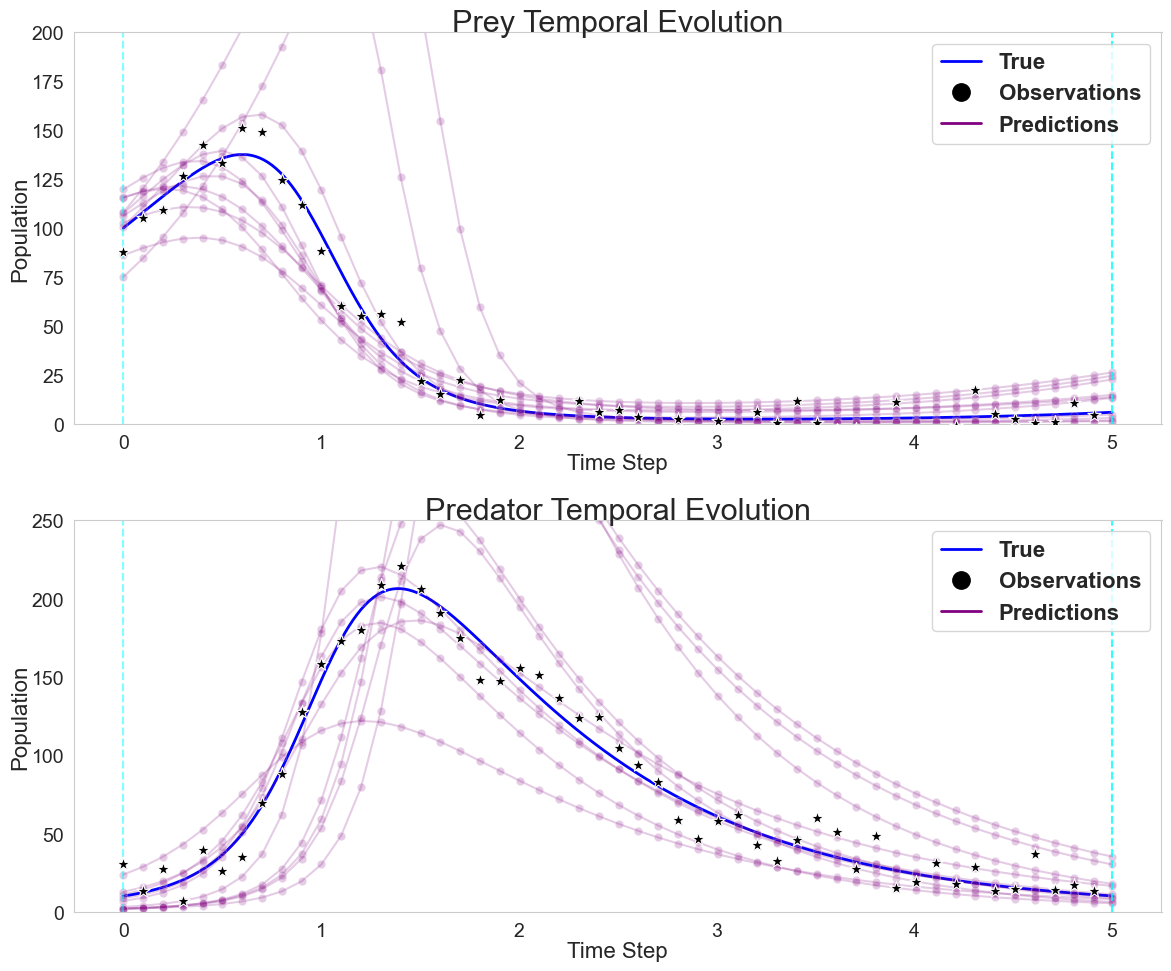

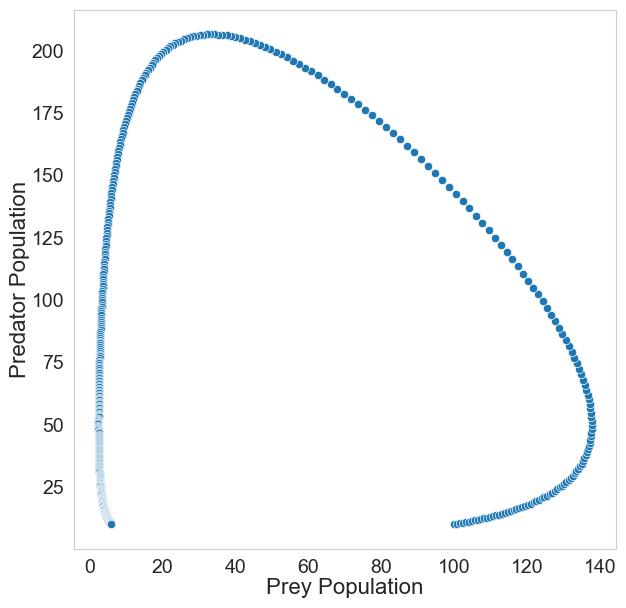

In [2]:
axs = lvm_b2020.plot_states()
labels = ["True",
        "Observations",
        "Predictions"
        ]
styles = ["solid","None","solid"]
colors = ["blue","black","purple"]
leg_args = dict(font_size=plt.rcParams.get('legend.fontsize'), line_width=2, location='upper right')
create_legend(
    axs[0], colors, styles, labels, **leg_args
)
create_legend(
    axs[1], colors, styles, labels, **leg_args
)
axs[0].set_ylim([0, 200])
axs[1].set_ylim([0, 250])
ax = lvm_b2020.plot_true_phase_space()

num_ts = len(lvm_b2020.data[0].dropna())
full_num_data = num_ts * 2

## Solving us $Q_{PCA}$ Map

[11/19/23 20:36:43] INFO     Logger enabled                                                               ]8;id=187890;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=871668;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 10000                                         │
│ num_params  │ 4                                             │
│ num_qoi     │ 102                                           │
│ num_states  │ 4                                             │
│ mem_usage   │ 8.94 KB                                       │
│ solved      │ True                                          │
│ lam_mud     │ [1.0104557  0.01807043 0.02965012 1.05265434] │
│ mud_idx     │ 3541                                          │
│ e_r         │ 1.0222293214028608                            │
│ kl          │ 3.909709871410708                             │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

<Figure size 640x480 with 0 Axes>

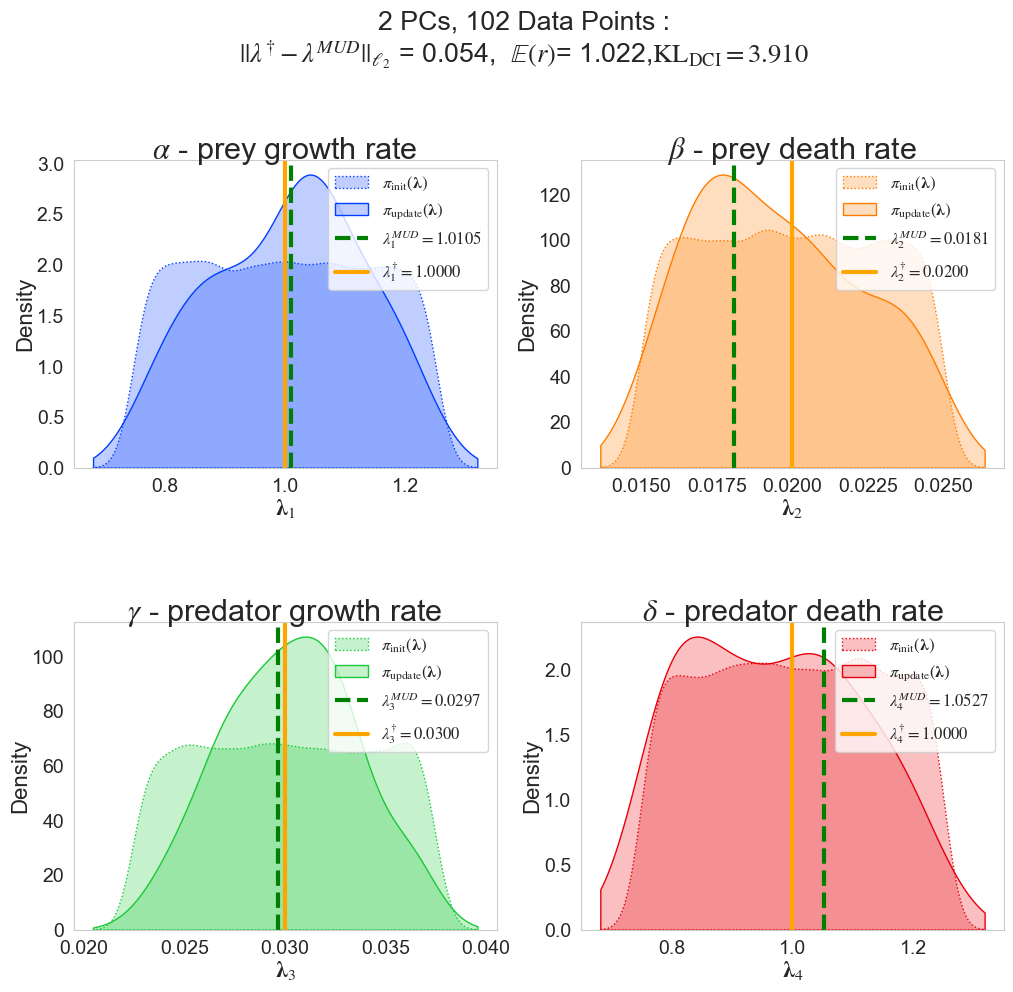

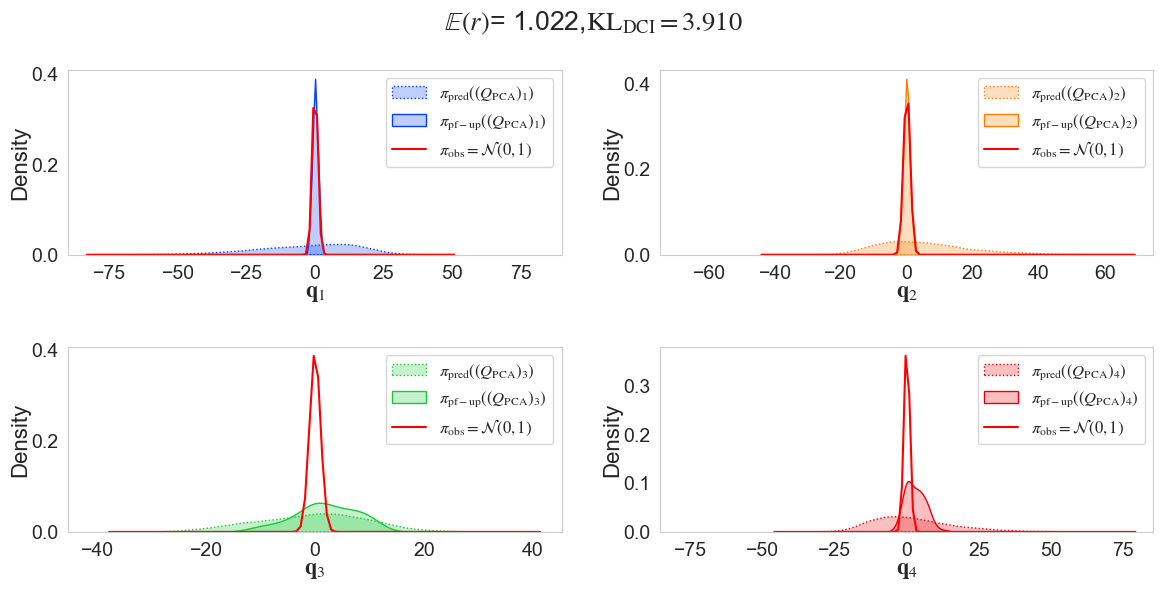

In [13]:
enable_log(level='INFO')

n_pca = 2

pca_prob_b2020 = PCAMUDProblem(lvm_b2020.samples[0], lvm_b2020.data[0], lvm_b2020.measurement_noise, pi_in=pi_in_b2020)
pca_prob_b2020.solve(pca_components=range(n_pca), pca_mask=range(full_num_data))
plt.subplots_adjust(hspace=0.5)
print(pca_prob_b2020)

axes = pca_prob_b2020.param_density_plots(lam_true=np.array(LV_P1_b2020), figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)

# Set each title to the param: short explanation for each lam_i in ax
param_titles ={
    0:rf'$\alpha$ - prey growth rate',
    1:rf'$\beta$ - prey death rate',
    2:rf'$\gamma$ - predator growth rate',
    3:rf'$\delta$ - predator death rate'}

for i, ax in enumerate(axes.flat):
    title = ax.get_title()
    ax.set_title(param_titles[i])
# Add whitespace between subplots
plt.subplots_adjust(hspace=0.5)
fig = plt.gcf()
title = fig._suptitle.get_text()

fig.suptitle(f'{n_pca} PCs, {full_num_data} Data Points :\n' + title, y=1.03)

pca_prob_b2020.state_density_plots()
plt.subplots_adjust(hspace=0.5)

[11/19/23 20:36:46] INFO     Logger enabled                                                               ]8;id=615974;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=758975;file:///Users/cnegrete/repos/pyDCI/src/pydci/log.py#87\87]8;;\

                         PCAMUDProblem                         
┌─────────────┬───────────────────────────────────────────────┐
│ num_samples │ 10000                                         │
│ num_params  │ 4                                             │
│ num_qoi     │ 102                                           │
│ num_states  │ 4                                             │
│ mem_usage   │ 8.94 KB                                       │
│ solved      │ True                                          │
│ lam_mud     │ [1.0104557  0.01807043 0.02965012 1.05265434] │
│ mud_idx     │ 3541                                          │
│ e_r         │ 1.4618822724982752                            │
│ kl          │ 5.3477992649997415                            │
│ error       │ None                                          │
└─────────────┴───────────────────────────────────────────────┘

<Figure size 640x480 with 0 Axes>

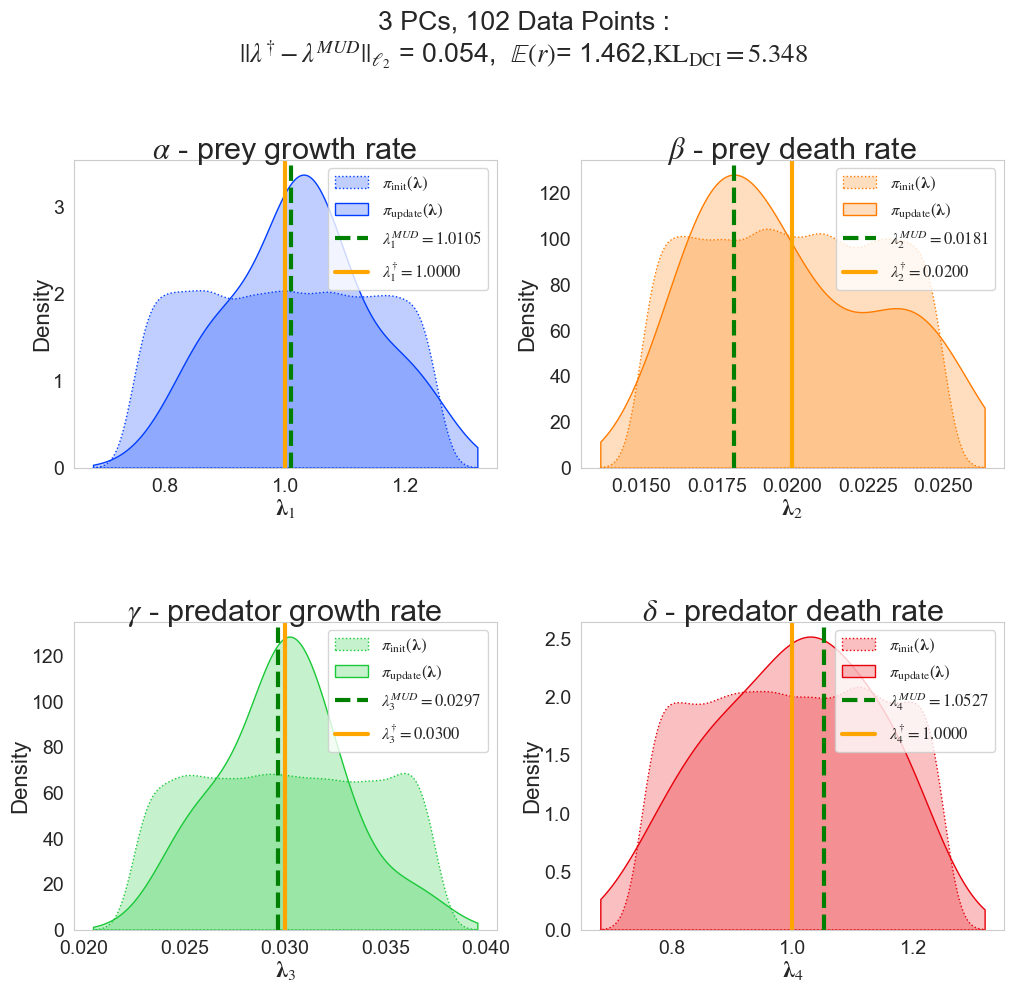

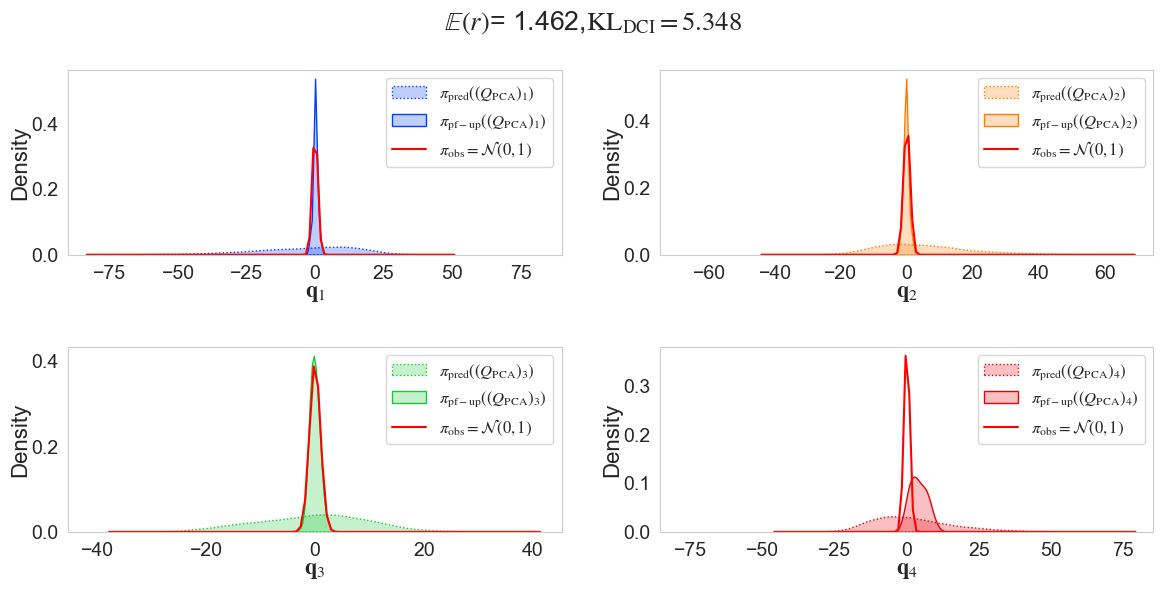

In [14]:
enable_log(level='INFO')

n_pca = 3

pca_prob_b2020 = PCAMUDProblem(lvm_b2020.samples[0], lvm_b2020.data[0], lvm_b2020.measurement_noise, pi_in=pi_in_b2020)
pca_prob_b2020.solve(pca_components=range(n_pca), pca_mask=range(full_num_data))
plt.subplots_adjust(hspace=0.5)
print(pca_prob_b2020)

axes = pca_prob_b2020.param_density_plots(lam_true=np.array(LV_P1_b2020), figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)

# Set each title to the param: short explanation for each lam_i in ax
param_titles ={
    0:rf'$\alpha$ - prey growth rate',
    1:rf'$\beta$ - prey death rate',
    2:rf'$\gamma$ - predator growth rate',
    3:rf'$\delta$ - predator death rate'}

for i, ax in enumerate(axes.flat):
    title = ax.get_title()
    ax.set_title(param_titles[i])
# Add whitespace between subplots
plt.subplots_adjust(hspace=0.5)
fig = plt.gcf()
title = fig._suptitle.get_text()

fig.suptitle(f'{n_pca} PCs, {full_num_data} Data Points :\n' + title, y=1.03)

pca_prob_b2020.state_density_plots()
plt.subplots_adjust(hspace=0.5)

## Searching for best solution - Offlien Sequential Search

In [5]:
# enable_log(level='INFO')
disable_log()
oss_b2020 = OfflineSequentialSearch(lvm_b2020.samples[0], lvm_b2020.data[0], lvm_b2020.measurement_noise, pi_in=pi_in_b2020)
oss_b2020.solve(**search_params)
oss_b2020.results

e_r        kl  k_eff  k_eff_up  solved error  lam_MUD_0  lam_MUD_1  \
0  1.013024  0.737672    1.0    0.8967    True  None   0.834945   0.020663   
0  1.026022  1.908070    1.0    0.3515    True  None   0.805143   0.019897   
0  1.017156  2.440483    1.0    0.2116    True  None   0.986343   0.022156   
0  1.033211  2.470736    1.0    0.2218    True  None   1.139235   0.019629   
0  1.043991  1.131834    1.0    0.8656    True  None   1.053370   0.018957   
0  1.027557  3.347699    1.0    0.1947    True  None   0.978393   0.024734   
0  1.081804  4.982085    1.0    0.0364    True  None   0.937197   0.022280   
0  1.233225  4.875390    1.0    0.0464    True  None   0.894936   0.016539   
0  1.037168  1.276156    1.0    0.8538    True  None   1.247510   0.016304   
0  1.039241  3.850644    1.0    0.1502    True  None   1.103591   0.021361   
0  1.229002  6.309370    1.0    0.0200    True  None   0.897027   0.022227   
0  2.084424  6.133155    1.0    0.0212    True  None   1.199739   0.020077   
0  0.689284  1.680525    1.0    0.8115    True  None   1.004458   0.023493   
0  1.262973  4.480425    1.0    0.1294    True  None   1.103591   0.021361   
0  1.623810  6.908249    1.0    0.0172    True  None   0.817513   0.017568   
0  3.192175  7.468095    1.0    0.0124    True  None   1.216549   0.022530   

   lam_MUD_2  lam_MUD_3  ...       pca_mask  i  I  search_index  \
0   0.034609   0.981004  ...   range(0, 10)  1  1             0   
0   0.036980   1.162908  ...   range(0, 20)  1  1             1   
0   0.024100   1.236161  ...   range(0, 50)  1  1             2   
0   0.031336   1.213400  ...  range(0, 100)  1  1             3   
0   0.025137   1.207937  ...   range(0, 10)  1  1             4   
0   0.030054   1.062256  ...   range(0, 20)  1  1             5   
0   0.030782   0.937270  ...   range(0, 50)  1  1             6   
0   0.032448   1.229031  ...  range(0, 100)  1  1             7   
0   0.033450   1.052249  ...   range(0, 10)  1  1             8   
0   0.029622   1.040797  ...   range(0, 20)  1  1             9   
0   0.030860   0.758361  ...   range(0, 50)  1  1            10   
0   0.026092   0.991188  ...  range(0, 100)  1  1            11   
0   0.037277   0.794309  ...   range(0, 10)  1  1            12   
0   0.029622   1.040797  ...   range(0, 20)  1  1            13   
0   0.032337   1.095243  ...   range(0, 50)  1  1            14   
0   0.025591   0.883888  ...  range(0, 100)  1  1            15   

   predict_delta  within_thresh  valid  closest  max_kl  min_kl  
0       0.013024           True   True     True   False    True  
0       0.026022           True   True    False   False   False  
0       0.017156           True   True    False   False   False  
0       0.033211           True   True    False   False   False  
0       0.043991           True   True    False   False   False  
0       0.027557           True   True    False   False   False  
0       0.081804           True   True    False   False   False  
0       0.233225           True   True    False   False   False  
0       0.037168           True   True    False   False   False  
0       0.039241           True   True    False   False   False  
0       0.229002           True   True    False    True   False  
0       1.084424          False  False    False   False   False  
0       0.310716          False  False    False   False   False  
0       0.262973           True   True    False   False   False  
0       0.623810          False  False    False   False   False  
0       2.192175          False  False    False   False   False  

[16 rows x 22 columns]

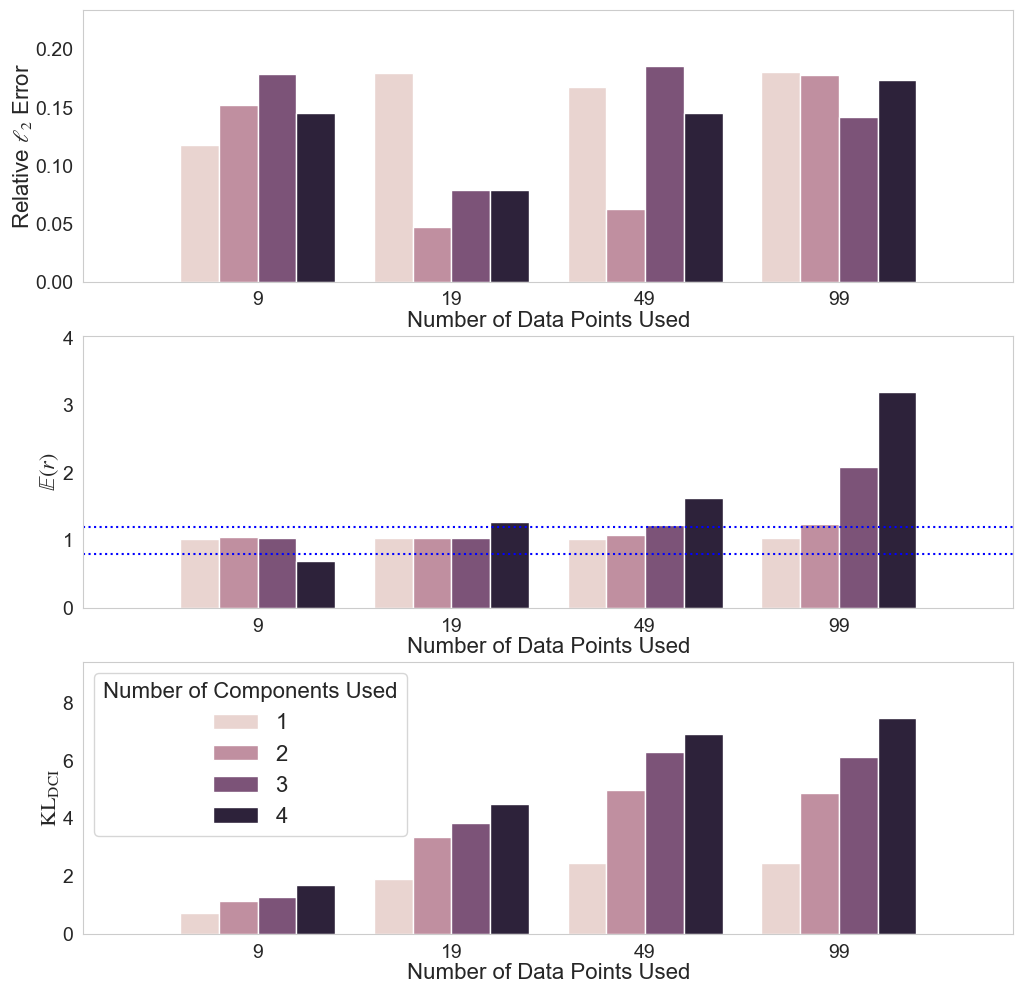

In [6]:
ax = oss_b2020.summary_barplots_by_num_data(lam_true=LV_P1_b2020)
ax[0].get_legend().remove()
ax[1].get_legend().remove()

### Best Solution

                        OfflineSequential                         
┌────────────────┬───────────────────────────────────────────────┐
│ num_samples    │ 10000                                         │
│ num_params     │ 4                                             │
│ num_qoi        │ 102                                           │
│ num_states     │ 4                                             │
│ num_iter       │ 1                                             │
│ mem_usage      │ 8.94 KB                                       │
│ solved         │ True                                          │
│ pca_components │ [0, 1, 2]                                     │
│ pca_mask       │ range(0, 50)                                  │
│ lam_mud        │ [0.89702722 0.02222661 0.0308595  0.75836094] │
│ mud_idx        │ 4548                                          │
│ e_r            │ 1.2290016916640127                            │
│ kl             │ 6.3093701291376085                            │
│ error          │ None                                          │
└────────────────┴───────────────────────────────────────────────┘

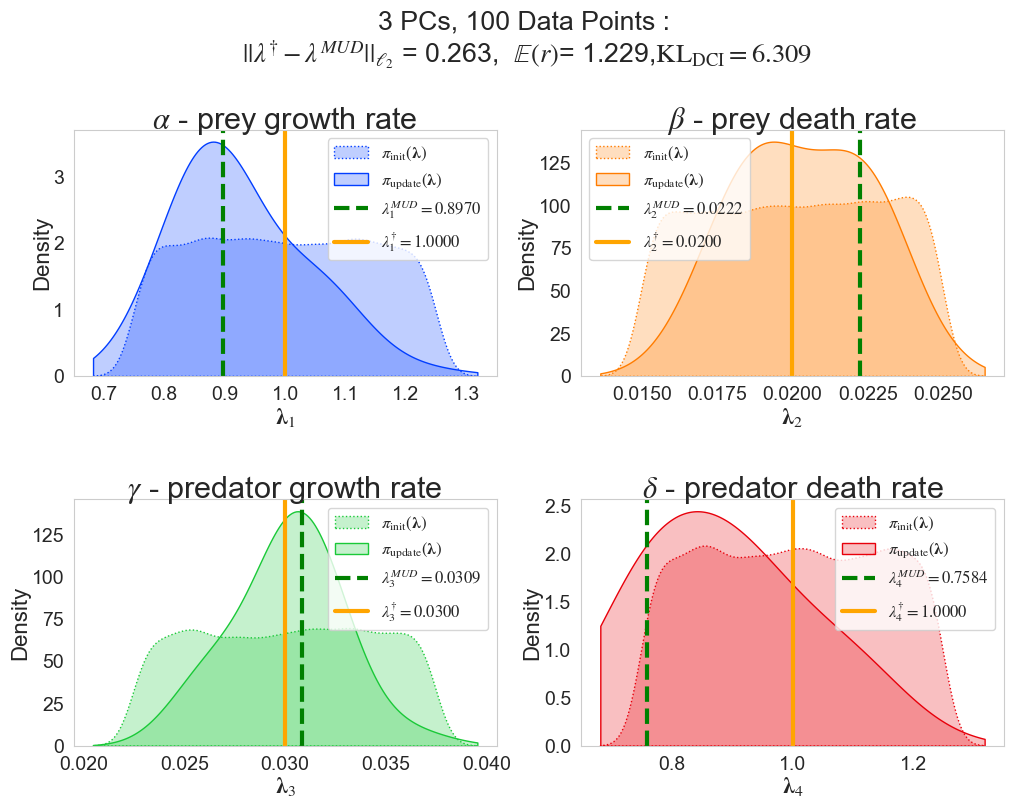

In [7]:
print(oss_b2020.best)
axes = oss_b2020.best.param_density_plots(lam_true=LV_P1_b2020)


for i, ax in enumerate(axes.flat):
    title = ax.get_title()
    ax.set_title(param_titles[i])

fig = plt.gcf()
# Get current fig suptitle
title = fig._suptitle.get_text()
fig.suptitle('3 PCs, 100 Data Points :\n' + title.split(':')[1], y=1.03)

# Add whitespace between subplots
plt.subplots_adjust(hspace=0.5)


## Repeated Trials

In [8]:
n_trials = 5
num_samples = int(1e3)
search_params = dict(
    max_nc=5,
    split_range=range(1, 2),
    mask_range=[11, 21, 51, 76, 101],
    best_method='max_kl',
    exp_thresh=0.5,
)

# enable_log(level='INFO')
disable_log()
trial_results = []
for i in range(n_trials):

    lvm_b2020 = lotka_volterra.LotkaVolterraModel(
        x0=LV_INIT_STATE_b2020,
        lam_true=LV_P1_b2020,
        solve_ts=solve_ts,
        measurement_noise=noise,
        sample_ts=sample_ts,
        param_mins=LV_PARAM_MINS_b2020,
        state_mins=LV_STATE_MINS_b2020,
    )

    # * Pull synthetic data
    lvm_b2020.get_data(t0=0.0, tf=10)

    # * Forward solve samples from an initial
    pi_in_b2020, samples = lvm_b2020.get_uniform_initial_samples(num_samples=num_samples, scale=0.25)
    lvm_b2020.forward_solve(samples=samples)

    logger.info(f'Iteration {i}')
    oss_b2020 = OfflineSequentialSearch(lvm_b2020.samples[0], lvm_b2020.data[0], lvm_b2020.measurement_noise, pi_in=pi_in_b2020)
    oss_b2020.solve(**search_params)
    trial_results.append(oss_b2020.results)

trial_results = oss_b2020.process_results(LV_P1_b2020, results_df=pd.concat(trial_results))
trial_results

[11/19/23 16:33:51] INFO     Iteration 0                                                           ]8;id=214396;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py\1709284288.py]8;;\:]8;id=589460;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py#33\33]8;;\

[11/19/23 16:33:54] INFO     Iteration 1                                                           ]8;id=227211;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py\1709284288.py]8;;\:]8;id=420535;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py#33\33]8;;\

[11/19/23 16:33:58] INFO     Iteration 2                                                           ]8;id=901149;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py\1709284288.py]8;;\:]8;id=283866;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py#33\33]8;;\

[11/19/23 16:34:04] INFO     Iteration 3                                                           ]8;id=231382;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py\1709284288.py]8;;\:]8;id=903557;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py#33\33]8;;\

[11/19/23 16:34:08] INFO     Iteration 4                                                           ]8;id=830949;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py\1709284288.py]8;;\:]8;id=665245;file:///var/folders/0z/2dk6b0tn00z3_9kgytdmk9f00000gq/T/ipykernel_16885/1709284288.py#33\33]8;;\

e_r        kl  k_eff  k_eff_up  solved error  lam_MUD_0  lam_MUD_1  \
0  0.953821  2.132369    1.0     0.325    True  None   1.014849   0.021637   
0  1.067424  2.560383    1.0     0.202    True  None   0.818729   0.015020   
0  1.047562  2.437629    1.0     0.208    True  None   0.965111   0.017036   
0  1.152411  2.298390    1.0     0.232    True  None   1.138741   0.019205   
0  1.093383  3.343002    1.0     0.156    True  None   1.239048   0.021511   
0  1.371991  5.155329    1.0     0.034    True  None   0.818729   0.015020   
0  2.163902  4.365778    1.0     0.039    True  None   1.203534   0.022632   
0  1.501931  4.380039    1.0     0.043    True  None   1.065340   0.019282   
0  1.321404  4.586638    1.0     0.118    True  None   1.227300   0.018500   
0  0.950962  5.385215    1.0     0.018    True  None   1.222570   0.021691   
0  3.343315  5.595428    1.0     0.023    True  None   0.995183   0.017384   
0  0.402058  5.380019    1.0     0.030    True  None   1.065340   0.019282   
0  1.032662  1.978137    1.0     0.331    True  None   0.764208   0.021189   
0  1.206406  2.187454    1.0     0.235    True  None   0.966723   0.024905   
0  1.037889  2.420242    1.0     0.211    True  None   0.787063   0.023561   
0  1.034194  2.327809    1.0     0.237    True  None   1.170891   0.019488   
0  1.053719  3.379710    1.0     0.194    True  None   0.944167   0.023407   
0  2.260704  4.945733    1.0     0.032    True  None   0.915681   0.017560   
0  0.422797  4.636977    1.0     0.043    True  None   1.161178   0.017512   
0  0.570017  4.715089    1.0     0.058    True  None   0.798609   0.015712   
0  0.974180  4.043477    1.0     0.162    True  None   1.136105   0.020554   
0  4.315264  5.822571    1.0     0.022    True  None   0.912442   0.024738   
0  1.421535  5.300529    1.0     0.025    True  None   1.161178   0.017512   
0  0.631036  5.307523    1.0     0.027    True  None   0.938099   0.021469   
0  1.219497  1.870779    1.0     0.334    True  None   0.977758   0.018087   
0  1.021780  2.489281    1.0     0.210    True  None   1.087507   0.017785   
0  0.817838  2.712322    1.0     0.189    True  None   1.016666   0.022341   
0  1.188519  2.374709    1.0     0.218    True  None   0.874856   0.022150   
0  1.532087  3.000230    1.0     0.191    True  None   0.996128   0.017996   
0  0.292503  5.142194    1.0     0.035    True  None   0.959206   0.020694   
0  0.386817  5.667173    1.0     0.040    True  None   0.959206   0.020694   
0  1.508528  5.180977    1.0     0.044    True  None   0.846050   0.022014   
0  1.548242  3.737997    1.0     0.155    True  None   0.959206   0.020694   
0  0.313149  5.574129    1.0     0.024    True  None   0.959206   0.020694   
0  2.314582  5.936863    1.0     0.024    True  None   0.959206   0.020694   
0  0.341083  5.843211    1.0     0.020    True  None   0.959206   0.020694   
0  0.969712  2.147333    1.0     0.308    True  None   0.801576   0.017441   
0  0.910391  2.687309    1.0     0.196    True  None   1.019147   0.019154   
0  1.151030  2.585445    1.0     0.172    True  None   0.926837   0.017665   
0  0.807185  2.590605    1.0     0.215    True  None   0.752194   0.022932   
0  0.834384  3.794441    1.0     0.184    True  None   0.926837   0.017665   
0  3.266471  4.605229    1.0     0.033    True  None   1.225968   0.024620   
0  0.789429  4.734124    1.0     0.033    True  None   0.972856   0.018260   
0  1.219950  4.741597    1.0     0.043    True  None   0.852730   0.020763   
0  1.492327  5.206397    1.0     0.124    True  None   0.854922   0.017395   
0  0.321578  5.844033    1.0     0.024    True  None   1.179565   0.023088   
0  1.906420  5.170239    1.0     0.019    True  None   1.225968   0.024620   
0  0.083888  5.352372    1.0     0.027    True  None   1.048454   0.019879   
0  1.176845  1.823971    1.0     0.356    True  None   1.110320   0.022436   
0  1.012409  2.436666    1.0     0.214    True  None   0.890245   0.021199   
0  0.951239  2.791203    1.0  

[None, None, None]

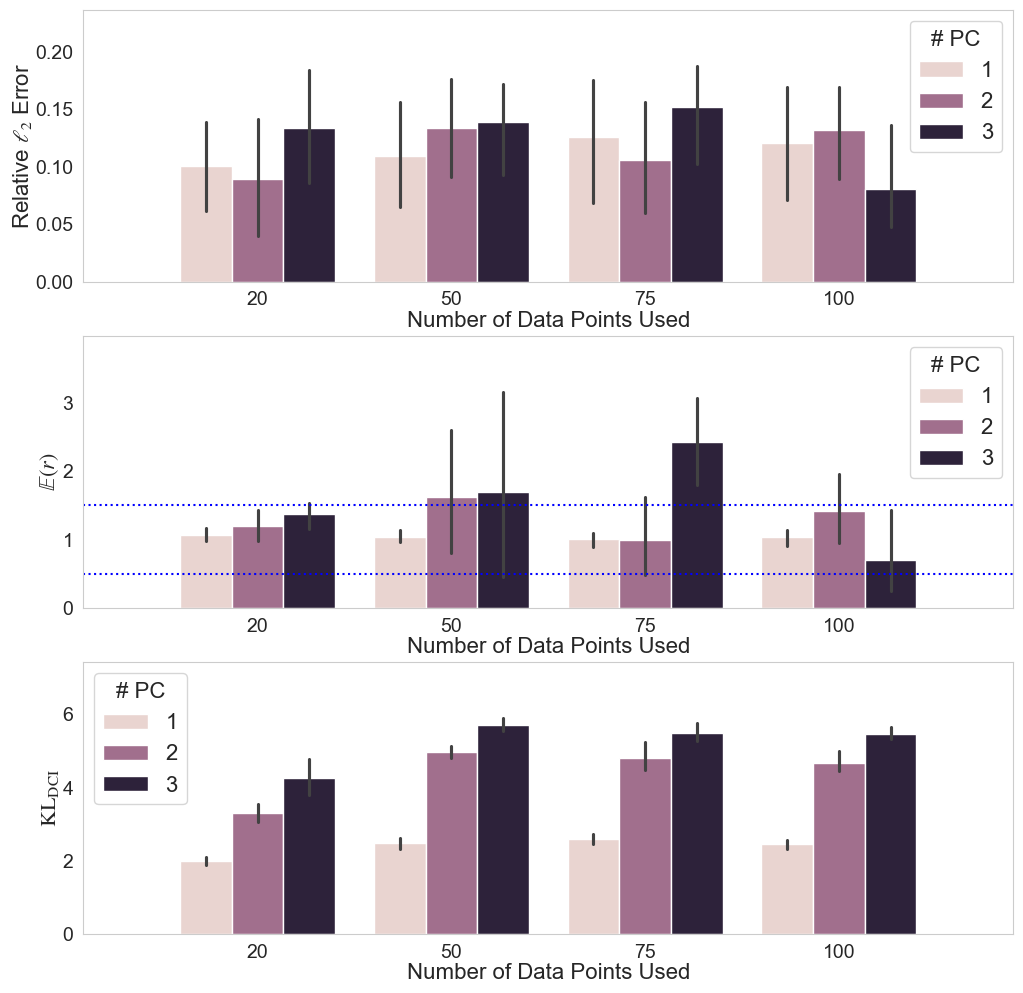

In [9]:
ax = oss_b2020.summary_barplots_by_num_data(LV_P1_b2020, results_df=trial_results, e_r_thresh=search_params['exp_thresh'])
[a.get_legend().set_title('# PC') for a in ax]

                        OfflineSequential                         
┌────────────────┬───────────────────────────────────────────────┐
│ num_samples    │ 1000                                          │
│ num_params     │ 4                                             │
│ num_qoi        │ 202                                           │
│ num_states     │ 4                                             │
│ num_iter       │ 1                                             │
│ mem_usage      │ 1.66 KB                                       │
│ solved         │ True                                          │
│ pca_components │ [0, 1]                                        │
│ pca_mask       │ range(0, 51)                                  │
│ lam_mud        │ [1.18380706 0.02250819 0.02682788 1.0480349 ] │
│ mud_idx        │ 452                                           │
│ e_r            │ 0.9352884560152305                            │
│ kl             │ 5.0129598524091                               │
│ error          │ None                                          │
└────────────────┴───────────────────────────────────────────────┘

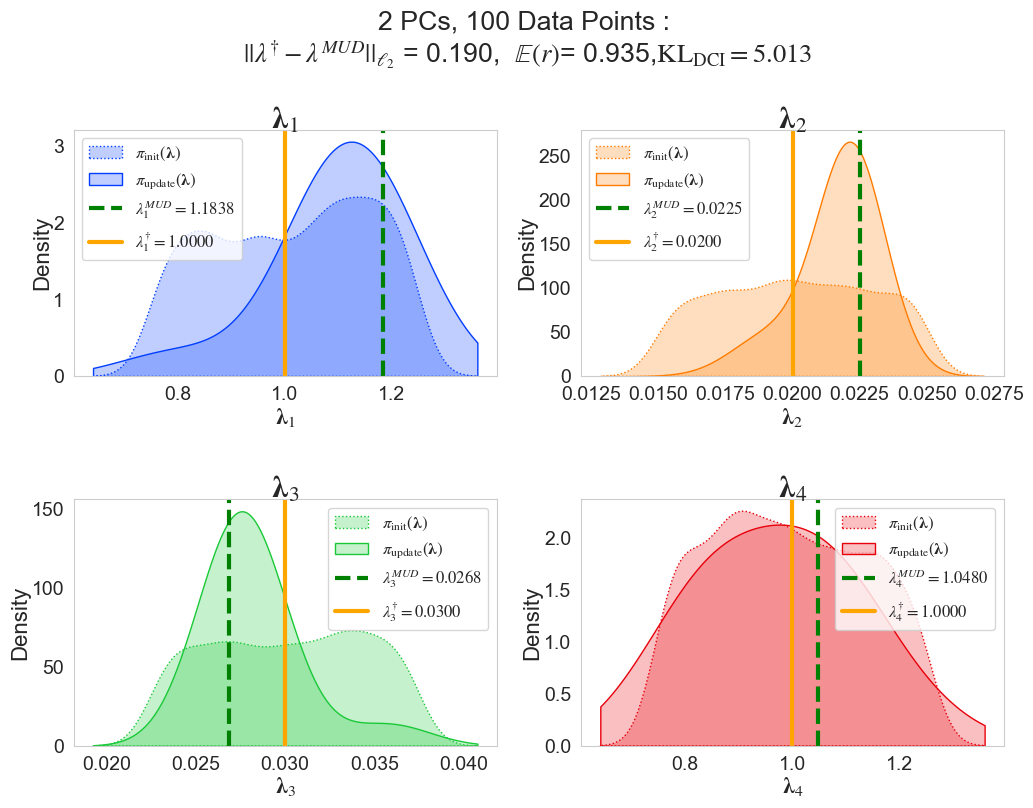

In [11]:
print(oss_b2020.best)

oss_b2020.best.param_density_plots(lam_true=LV_P1_b2020)

fig = plt.gcf()
# Get current fig suptitle
title = fig._suptitle.get_text()
fig.suptitle('2 PCs, 100 Data Points :\n' + title.split(':')[1], y=1.03)

# Add whitespace between subplots
plt.subplots_adjust(hspace=0.5)
